In [1]:
import numpy             as     np
import math
import matplotlib.pyplot as     plt
from   astropy.table     import Table
from   astropy.cosmology import FlatLambdaCDM
from   matplotlib.pyplot import cm
import matplotlib
from   scipy.special     import gamma
from   scipy             import interpolate
import pickle
import time
import progressbar

#For making multiple page pdfs
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# _________________________________________________________
# _________________________________________________________
#-- Import files--#
#                                       ... must always run
# _________________________________________________________

#First import the catalogue into an astropy.table (This is the catalogue I made with physical units included)
print('Reading in catalogues...')

#Path where all the files are for this/ where this code is located
#path = '/Users/jenniferhardwick/Desktop/OneDrive - The University of Western Australia/PhD/xGASS_Decomposition_Catalogue/'
path = '/home/jenniferhardwick/Insync/21514305@student.uwa.edu.au/OneDrive Biz/PhD/xGASS_Decomposition_Catalogue/'

#-------
#-------
#Switch to True or False depending if you want to have MW Extinction Correction applied
MW_Extinction_On = True
#-------
#-------


if MW_Extinction_On:
    #MW Extinction Correction applied
    mydata = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL+MWExtinction.fits')
else:
    #No MW Extinction Correction applier
    mydata = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL.fits')


RepSample = Table.read(path+'Catalogues/xGASS_representative_sample.fits')

robdata = Table.read(path+'Catalogues/xGASS_reM_decomp_measurements.fits')

master_robdata = Table.read(path+'Catalogues/xGASS_Bulge-Disk_Decomposition_Master_10-09-19.csv')

for comp in ['D','B','']:
    for band in ['g','r','i']:
        mydata['re'+comp+'_'+band+'_arcsec'] = mydata['re'+comp+'_'+band]*0.396
        mydata['re'+comp+'_'+band+'_err_arcsec'] = mydata['re'+comp+'_'+band+'_err']*0.396

order = []
for i in range(len(robdata['GASSID'])): #For every id in robins data
    order.append(np.argwhere(mydata['GASSID'] == robdata['GASSID'][i])[0][0]) #find that ID in mydata and record its location
        
        
print('Catalogues loaded')

Reading in catalogues...
Catalogues loaded


In [3]:
#When converting between pandas and astropy tables, for some reason nan's are overwritten with 1.000e20. So I am just manually changing them back...

key = mydata.keys()

for k in key:
    for idx in range(len(mydata[k])):
        if type(mydata[k][idx]) != str:
            if mydata[k][idx] >= 1.00*10**20:
                mydata[k][idx] = np.nan

In [4]:
# _________________________________________________________
# _________________________________________________________
#-- Helful Functions --#
#                                       ... must always run
# _________________________________________________________

def Sersic_Intensity_Profile(R,Re,Ie,n):
    ''' 
    This gives a surface density profile from a sersic profile:
    Sigma(R) = Ie * exp(-bn((R/Re)**(1/n)-1))    
    (bn is a numerical coefficient that depends on n)

    Parameters
    ----------
    R : list or array
        Radii that the sersic profile will be defined over [arcsec]
    Re : float
        The effective radius/ half-light radius [arcsec]
    Ie : float
        The intensity at Re [W.m^-2.Hz^-1.arcsec^-2]
    n  : float
        The sersic index [unit-less]

    Returns
    -------
    list or array 
        Light Intensity Sersic profile at each R value [W.m^-2.Hz^-1.arcsec^-2]

    '''
    
    bn = (2*n) - (1.0/3.0) + (0.009876/float(n))
    return Ie*np.e**( -bn*((R/Re)**(1.0/float(n))-1) )


def Sersic_SurfaceDensity_Profile(R,Re,Ie,n,mzero):
    '''
    This calculates the sersic profile as a surface density profile
    Taken from Graham and Driver 2005 eqn 6

    Parameters
    ----------
    R : list or array
        Radii that the sersic profile will be defined over [arcsec]
    Re : float
        The effective radius/ half-light radius [arcsec]
    Ie : float
        The intensity at Re [W.m^-2.Hz^-1.arcsec^-2]
    n  : float
        The sersic index [unit-less]
    mzero: float
        Magnitude Zero point for all galaxies [W.m^-2.Hz^-1]

    Returns
    -------
    list or array 
        Surface Density profile defined by a sersic profile, at each R value [mag.arcsec^-2]    
    '''
    
    mu_e = -2.5*np.log10(Ie) + mzero
    bn = (2*n) - (1.0/3.0) + (0.009876/float(n))
    return mu_e + (2.5*bn/np.log(10))*((R/Re)**(1/n)-1)


def NumericalIntegral(R,Func):
    '''
    This integrates a function numerically, within the maximum R value given.
    
    Parameters
    ----------
    R : array
        Radial values of the function
        
    Func: array
        Values of a function at each radii that is to be integrated numerically
    
    Returns
    -------
    float 
        Gives the numerical integral within the maximum R value
    '''
    i = range(0,len(R)-1)
    one = np.repeat(1,len(R)-1)
    return np.nansum(np.nanmean([Func[i],Func[i+one]])*(R[i+one]-R[i]))


def Ie(Re,n,m,mzero):
    '''
    Intensity at the effective radius (Formulas taken from the ProFit paper)
    
    Parameters
    ----------
    Re: list or array
        Effective radii for all galaxies [arcsec]
    n: list or array
        Sersic index for all galaxies [unit-less]
    m: list or array
        Apparent magnitude for all galaxies [mags]
    mzero: list or array
        Magnitude Zero point for all galaxies [W.m^-2.Hz^-1]
    
    Returns
    -------
    1D numpy array 
        The Intensity at the effective radius for all galaxies [W.m^-2.Hz^-1.arcsec^-2]   
    '''
    
    Re    = np.array(Re).astype(float)
    n     = np.array(n).astype(float)
    m     = np.array(m).astype(float)
    mzero = np.array(mzero).astype(float)
    
    b = (2*n) - (1.0/3.0) + (0.009876/n)
    Ltot = (2*np.pi*Re**2*n*gamma(2*n)*np.exp(b)) / (b**(2*n))
    return 10**(-0.4*(m-mzero))/Ltot

def StellarMass(mu_r,colour):
    '''
    Stellar mass profile of an individual galaxy. These surface density profiles are used after the distance modulus is subtracted (absolute mags.arcsec^-2)
    These input profiles need to all be in the same radial bins
    
    Parameters
    ----------
    mu_r: list or array
        Surface density profile of r band [mags.arcsec^-2]
    color: list or array
        Surface density profile of g - i [mags.arcsec^-2]
    
    Returns
    -------
    array or list 
        The stellar mass profile of an individual galaxy [Msun.arcsec^-2]   
        
    '''
    return 0.883 - 0.4*np.array(mu_r) + 1.157*(np.array(colour))

def find_xValue_given_yValue_in_yProfile(y_value,x_range,y_profile):
    '''
    Function to find the location of a y value in a y profile.
    
    Parameters
    ----------
    y_value: float
        The y value (in the y profile), that we want to find the equivalent x value of in the profile, [in the same units as the y_profile]
    x_range: list or array
        The corresponding x values of the y profile
    y_profile: list or array
        The y profile that you want to find the y value in, [in the same units as the y_value]
    
    Returns
    -------
    float 
        The value of x that corresponds with the y value entered in the profile  
        
    '''
    #We pick the two bins on either side of the y_value. In-between these bins will be the x value we are looking for
    min_index = np.argwhere(y_profile < y_value)[-1][0]
    max_index = np.argwhere(y_profile > y_value)[0][0]

    #Then we interpolate between these two points to expand the region we can determine the x value in
    new_x = np.linspace(x_range[min_index],x_range[max_index],num=1000000)
    Refined_profile = np.interp(new_x,x_range[min_index:max_index+1],y_profile[min_index:max_index+1])

    #Again pick the x bins on either side of the y value we are trying to find. 
    new_min_index = np.argwhere(Refined_profile < y_value)[-1][0]
    new_max_index = np.argwhere(Refined_profile > y_value)[0][0]
    
    #Finally we define the x value we are looking for.
    return np.mean([new_x[new_min_index],new_x[new_max_index]])
    
    
def intersection(lst1, lst2):
    '''
    A function I got off stack exchange for finding the intersection of two lists.
    '''
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def save_obj(obj, name ):
    '''
    code taken from: https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file/32216025
    It saves an object to a pickel file (I think?)
    
    name should be a string version of obj name (I think)
    '''
    with open(path+'obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    '''
    code taken from: https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file/32216025
    It saves an object to a pickel file (I think?)
    
    name should be a string version of obj name (I think)
    '''
    with open(path+'obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)


In [5]:
# _________________________________________________________
# _________________________________________________________
#-- Defining Things for later --#
#                                       ... must always run
# _________________________________________________________

#Defining the galaxies which we want to analyse. At the moment we are just looking at two component galaxies.
twoComp_galaxies = np.argwhere(mydata['Model']==0)#[::70] #[::70] -> is what is used to get the plots with the random 10 galaxies
pure_disks       = np.argwhere(mydata['Model']==1)
pure_bulges      = np.argwhere(mydata['Model']==2)

#Define our cosmology to be flat with the following values.
cosmo = FlatLambdaCDM(H0=70,Om0=0.3,Tcmb0 = 2.725)

In [12]:
# _________________________________________________________
# _________________________________________________________
#-- Calculate half light radii (Re) for B+D = T profiles --#
# _________________________________________________________

#Define Dictionaries for use in this chunk
I_wrt_r          = {}
I_within_r       = {}

I_wrt_r['D']     = {}
I_wrt_r['B']     = {}
I_wrt_r['T']     = {}
I_wrt_r['']      = {}

I_within_r['T']  = {}

reT_arcsec       = {}
reT_kpc          = {}


for band in ['g','r','i']:
    print(' -- Begining '+band+' band effective radii calculations...')
    
    # -- Define dictionaries within the dictionaries for each band (g, r & i)
    I_wrt_r['D'][band]     = {}
    I_wrt_r['B'][band]     = {}
    I_wrt_r['T'][band]     = {}
    I_wrt_r[''][band]      = {}
    
    I_within_r['T'][band]  = {}
    
    reT_arcsec[band]       = []
    
    z         = mydata['zSDSS']
    
    # -- Units to remember:
    # Radii:          arcsec (so my final solution is mag.arcsec^-2)
    # sersic indices: unit-less
    # m:              apparent mag
    # mzero:          reference magnitude (in W.m^-2.Hz^-1)
    
    # -- Intensity at the effective radius
    
    ie_D      = Ie(mydata['reD_'+band+'_arcsec'],mydata['nserD_'+band],mydata['magD_'+band],mydata['magzero_'+band]) #W.m^-2.Hz^-1.arcsec^-2
    ie_B      = Ie(mydata['reB_'+band+'_arcsec'],mydata['nserB_'+band],mydata['magB_'+band],mydata['magzero_'+band]) #W.m^-2.Hz^-1.arcsec^-2
    ie_single = Ie(mydata['re_'+band+'_arcsec'], mydata['nser_'+band], mydata['mag_'+band], mydata['magzero_'+band]) #W.m^-2.Hz^-1.arcsec^-2
    
    
    # -- loop over all galaxies
    with progressbar.ProgressBar(max_value=len(z)) as bar:
        for i in range(len(z)):
            
            if mydata['Model'][i] == -1:
                #If they aren't fit with a model I enter a nan as a place holder
                reT_arcsec[band].append(float('nan'))
                
            else:
                # -- Define the radii the intensitymydata['magzero_'+band] profiles will be over
                R = np.linspace(0,10*mydata['reD_r_arcsec'][i],num=1000)
                
                # -- Determine the intensity profiles from a sersic shape for each component
                I_wrt_r['D'][band][i] = Sersic_Intensity_Profile(R,mydata['reD_'+band+'_arcsec'][i],ie_D[i],     mydata['nserD_'+band][i])
                I_wrt_r['B'][band][i] = Sersic_Intensity_Profile(R,mydata['reB_'+band+'_arcsec'][i],ie_B[i],     mydata['nserB_'+band][i])
                I_wrt_r[''][band][i]  = Sersic_Intensity_Profile(R,mydata['re_'+band+'_arcsec'][i], ie_single[i],mydata['nser_'+band][i])

                # -- Sum the disk and bulge component to make the total profile (As these are intensities they can be added directly.)
                I_wrt_r['T'][band][i] = I_wrt_r['D'][band][i] + I_wrt_r['B'][band][i]

                #Define the starting point for the cumulative intensity profile
                I_within_r['T'][band][i] = [0]
                #Loop over all radii to make a cumulative intensity profile (this is for the half light radii)
                for j in range(1,len(R)):
                    I_within_r['T'][band][i].append(NumericalIntegral(R[:j+1],I_wrt_r['T'][band][i][:j+1]*(2*np.pi*R[:j+1])))

                #Finally we define the half light radius (in units of arcsecs as that is the units we have used in this code chunk)
                reT_arcsec[band].append(find_xValue_given_yValue_in_yProfile(I_within_r['T'][band][i][-1]/2.0,R,I_within_r['T'][band][i]))
            
            #Update Progress Bar
            time.sleep(0.01)
            bar.update(i)
    
    #Convert the arcsec half-light to kpc
    reT_kpc[band] = (reT_arcsec[band]/cosmo.arcsec_per_kpc_proper(z)).value
    
# _________________________________________________________
# _________________________________________________________
#-- Save variables into catalogue / to file --#
# _________________________________________________________

for band in ['g','r','i']:
    mydata['reT_'+band+'_arcsec'] = reT_arcsec[band]
    mydata['reT_'+band+'_kpc']    = reT_kpc[band]
 
if MW_Extinction_On:
    #MW Extinction
    mydata.write(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL+MWExtinction_v2.fits',overwrite=True)
    save_obj(I_wrt_r,name='I_wrt_r+MWExtinction')
    save_obj(I_within_r,name='I_within_r+MWExtinction') 
else:
    #No MW Extinction   
    mydata.write(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL_v2.fits',overwrite=True)
    save_obj(I_wrt_r,name='I_wrt_r')
    save_obj(I_within_r,name='I_within_r') 

print('Done :)')

 -- Begining g band effective radii calculations...


100% (1177 of 1177) |####################| Elapsed Time: 0:06:37 Time:  0:06:37


 -- Begining r band effective radii calculations...


100% (1177 of 1177) |####################| Elapsed Time: 0:06:47 Time:  0:06:47


 -- Begining i band effective radii calculations...


100% (1177 of 1177) |####################| Elapsed Time: 0:06:44 Time:  0:06:44


Done :)


In [ ]:
# _________________________________________________________
# _________________________________________________________
#-- Calculate Surface Density profiles --#
# _________________________________________________________
#This chunk of code calculates the surface density profiles

#Load in stuff from previous code chunks, so the whole notebook doesn't have to be run...
if MW_Extinction_On:
    #MW Extinction
    mydata     = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL+MWExtinction_v2.fits')
else:
    #NO MW Extinction
    mydata     = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL_v2.fits')

#--

sd     = {}
SD_abs = {}
R      = {}
R_kpc  = {}

for comp in ['D','B','']:
    if comp == 'D':
        print('Computing Disk Components')
    elif comp == 'B':
        print('Computing Bulge Components')
    elif comp == '':
        print('Computing Single Components')
        
    SD_abs[comp] = {}
    sd[comp]     = {}
    R[comp]      = {}
    R_kpc[comp]  = {}
    
    for band in ['g','r','i']:
        print(' -- Begining '+band+' band surface density calculations...')
        
        SD_abs[comp][band] = {}
        sd[comp][band]     = {}

        z         = mydata['zSDSS']
        Re        = mydata['re'+comp+'_'+band+'_arcsec'] #arcsec; so my final solution is mag.arcsec^-2
        n         = mydata['nser'+comp+'_'+band]  #unit-less
        m         = mydata['mag'+comp+'_'+band]  #apparent mag
        mzero     = mydata['magzero_'+band]  #reference magnitude (in W.m^-2.Hz^-1)
        ie        = Ie(Re,n,m,mzero) #W.m^-2.Hz^-1.arcsec^-2

        for i in range(len(z)):
            if comp == '':
                Re_r_MaxRange = mydata['re_r_arcsec'][i] #arcsec #This is the Re in r band, and is what I will use to get my range in R values.
            else:
                Re_r_MaxRange = mydata['reT_r_arcsec'][i] #arcsec #This is the Re in r band for the total component, (needs to be the same for disc and bulge to be added)
            R[comp][i] = np.linspace(0,10*Re_r_MaxRange,num=1000) #In units of arcsec #1000 bins evenly spaced between 0 and 10Re

            sd[comp][band][i] = Sersic_SurfaceDensity_Profile(R[comp][i],Re[i],ie[i],n[i],mzero[i]) #surface density (like apparent mags)
            #^ units is mags.arcsec^-2
            
            SD_abs[comp][band][i] = sd[comp][band][i] - cosmo.distmod(z[i]).value #surface density (like absolute mags)
            
            R_kpc[comp][i] = R[comp][i]/cosmo.arcsec_per_kpc_proper(z[i]) #In units of kpc incase you need it for anything

print('Computing Total Components')
SD_abs['T'] = {}
sd['T']     = {}
R['T']      = {}
R_kpc['T']  = {}
for band in ['g','r','i']:
    print(' -- Begining '+band+' band surface density calculations...')
    SD_abs['T'][band] = {}
    sd['T'][band]     = {}
    for i in range(len(z)):
        R['T'][i] = R['D'][i]
        
        sd['T'][band][i] = -2.5*np.log10(10**(-0.4*sd['B'][band][i])+10**(-0.4*sd['D'][band][i]))
        SD_abs['T'][band][i] = sd['T'][band][i] - cosmo.distmod(z[i]).value #surface density (like absolute mags)   
        
        R_kpc['T'][i] = R['T'][i]/cosmo.arcsec_per_kpc_proper(z[i]) #In units of kpc incase you need it for anything
        
        
# _________________________________________________________
# _________________________________________________________
#-- Save variables into catalogue / to file --#
# _________________________________________________________

#dictionaries that need to be saved for later...

if MW_Extinction_On:
    #MW Extinction
    save_obj(sd     ,name='sd+MWExtinction')
    save_obj(SD_abs ,name='SD_abs+MWExtinction') 
    save_obj(R      ,name='R+MWExtinction')
    save_obj(R_kpc  ,name='R_kpc+MWExtinction') 
else:
    #NO MW Extinction
    save_obj(sd     ,name='sd')
    save_obj(SD_abs ,name='SD_abs') 
    save_obj(R      ,name='R')
    save_obj(R_kpc  ,name='R_kpc') 

print('Done :)')

In [ ]:
# _________________________________________________________
# _________________________________________________________
#-- Calculate Stellar Mass profiles --#
# _________________________________________________________

#Load in stuff from previous code chunks, so the whole notebook doesn't have to be run...

if MW_Extinction_On:
    #MW Extinction
    mydata     = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL+MWExtinction_v2.fits')
    sd         = load_obj('sd+MWExtinction')
    SD_abs     = load_obj('SD_abs+MWExtinction')
else:
    #NO MW Extinction
    mydata     = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL_v2.fits')
    sd         = load_obj('sd')
    SD_abs     = load_obj('SD_abs')


#Stellar mass profile with repsect to r

logMstar_wrt_r     = {}
logMstar_wrt_r_fix = {}
g_i_colour         = {}
g_i_colour_fix     = {}

for comp in ['D','','T']:
    if comp == 'D':
        print('Calculating Disk Component Stellar Mass Profiles wrt R')
    elif comp == 'T':
        print('Calculating Total Component Stellar Mass Profiles wrt R')
    elif comp == '':
        print('Calculating Single Component Stellar Mass Profiles wrt R')
    logMstar_wrt_r[comp]     = {}
    logMstar_wrt_r_fix[comp] = {}
    g_i_colour[comp]         = {}
    g_i_colour_fix[comp]     = {}
    for i in range(len(z)):
        if mydata['Model'][i] == -1:
            logMstar_wrt_r[comp][i]     = float('nan')
            logMstar_wrt_r_fix[comp][i] = float('nan')
            g_i_colour[comp][i]         = float('nan')
            g_i_colour_fix[comp][i]     = float('nan')
        else:
            g_i_colour[comp][i] = np.array(SD_abs[comp]['g'][i])-np.array(SD_abs[comp]['i'][i])
            logMstar_wrt_r[comp][i] = StellarMass(SD_abs[comp]['r'][i],g_i_colour[comp][i]) #Msun.arcsec^-2

            loc_extrapolation = int(np.argwhere(sd[comp]['r'][i] < mydata['RMS'][i])[-1])
            g_i_colour_fix[comp][i] = g_i_colour[comp][i]
            g_i_colour_fix[comp][i][loc_extrapolation+1:] = g_i_colour[comp][i][loc_extrapolation]
            logMstar_wrt_r_fix[comp][i] = StellarMass(SD_abs[comp]['r'][i],g_i_colour_fix[comp][i]) #Msun.arcsec^-2
            
# _________________________________________________________
# _________________________________________________________
#-- Save variables into catalogue / to file --#
# _________________________________________________________

#dictionaries that need to be saved for later...

if MW_Extinction_On:
    #MW Extinction
    save_obj(logMstar_wrt_r    ,name='logMstar_wrt_r+MWExtinction')
    save_obj(logMstar_wrt_r_fix,name='logMstar_wrt_r_fix+MWExtinction') 
    save_obj(g_i_colour        ,name='g_i_colour+MWExtinction')
    save_obj(g_i_colour_fix    ,name='g_i_colour_fix+MWExtinction') 
else:
    #NO MW Extinction
    save_obj(logMstar_wrt_r    ,name='logMstar_wrt_r')
    save_obj(logMstar_wrt_r_fix,name='logMstar_wrt_r_fix') 
    save_obj(g_i_colour        ,name='g_i_colour')
    save_obj(g_i_colour_fix    ,name='g_i_colour_fix') 

print('Done :)')

In [ ]:
# _________________________________________________________
# _________________________________________________________
#-- Calculate Stellar Mass profiles within R (cumulative mass)--#
# _________________________________________________________

#Load in stuff from previous code chunks, so the whole notebook doesn't have to be run...

if MW_Extinction_On:
    #MW Extinction
    mydata             = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL+MWExtinction_v2.fits')
    I_wrt_r            = load_obj('I_wrt_r+MWExtinction')
    R                  = load_obj('R+MWExtinction')
    logMstar_wrt_r     = load_obj('logMstar_wrt_r+MWExtinction')
    logMstar_wrt_r_fix = load_obj('logMstar_wrt_r_fix+MWExtinction')
else:
    #NO MW Extinction
    mydata             = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL_v2.fits')
    I_wrt_r            = load_obj('I_wrt_r')
    R                  = load_obj('R')
    logMstar_wrt_r     = load_obj('logMstar_wrt_r')
    logMstar_wrt_r_fix = load_obj('logMstar_wrt_r_fix')

#--

print('Calculating Stellar Mass Profiles within R')
logMstar_within_r     = {}
logMstar_within_r_fix = {}

z = mydata['zSDSS']

for comp in ['D','','T']:
    if comp == 'D':
        print('-- Starting Disk Component --')
    elif comp == '':
        print('-- Starting Single Component --')
    elif comp == 'T':
        print('-- Starting Total Component --')
    logMstar_within_r[comp]     = {}
    logMstar_within_r_fix[comp] = {}
    
    with progressbar.ProgressBar(max_value=len(z)) as bar:
        for i in range(0,len(z)):
            #if i%10 == 0:
            #    print('   galaxies completed: {} out of 1177'.format(i))
            #elif i ==len(z)-1:
            #    print('Stellar Mass Profile Calculation Complete')
            logMstar_within_r[comp][i]     = [-5]
            logMstar_within_r_fix[comp][i] = [-5]

            if mydata['Model'][i] == -1:
                logMstar_within_r[comp][i]     = float('nan')
                logMstar_within_r_fix[comp][i] = float('nan')
            else:
                for j in range(1,len(logMstar_wrt_r[comp][i])):
                    logMstar_within_r[comp][i].append(np.log10(NumericalIntegral(R[comp][i][:j+1],10**logMstar_wrt_r[comp][i][:j+1]*(2*np.pi*R[comp][i][:j+1]))))
                    #R is in arcsecs and Mstar is in units of Msun/arcsec^2, therefore our final answer is in units of Msun (within R).
                    logMstar_within_r_fix[comp][i].append(np.log10(NumericalIntegral(R[comp][i][:j+1],10**logMstar_wrt_r_fix[comp][i][:j+1]*(2*np.pi*R[comp][i][:j+1]))))
                
            #Update Progress Bar
            time.sleep(0.1)
            bar.update(i)
                
                
# _________________________________________________________
# _________________________________________________________
#-- Save variables into catalogue / to file --#
# _________________________________________________________

#dictionaries that need to be saved for later...

if MW_Extinction_On:
    #MW Extinction
    save_obj(logMstar_within_r    ,name='logMstar_within_r+MWExtinction')
    save_obj(logMstar_within_r_fix,name='logMstar_within_r_fix+MWExtinction')
else:
    #NO MW Extinction
    save_obj(logMstar_within_r    ,name='logMstar_within_r')
    save_obj(logMstar_within_r_fix,name='logMstar_within_r_fix') 
    

print('Done :)')

In [ ]:
# _________________________________________________________
# _________________________________________________________
#-- Recover total stellar mass --#
# _________________________________________________________

#Load in stuff from previous code chunks, so the whole notebook doesn't have to be run...

if MW_Extinction_On:
    #MW Extinction
    mydata  = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL+MWExtinction_v2.fits')
    logMstar_within_r     = load_obj('logMstar_within_r+MWExtinction')
    logMstar_within_r_fix = load_obj('logMstar_within_r_fix+MWExtinction')
else:
    #NO MW Extinction
    mydata  = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL_v2.fits')
    logMstar_within_r     = load_obj('logMstar_within_r')
    logMstar_within_r_fix = load_obj('logMstar_within_r_fix')
    
#--

print('Recovering total stellar mass')

TotMstar_recover = {}
TotMstar_recover_fix = {}
z = mydata['zSDSS']

for comp in ['D','','T']:
    if comp == 'D':
        print('-- Starting Disk Component --')
    elif comp == '':
        print('-- Starting Single Component --')
    elif comp == 'T':
        print('-- Starting Total Component --')
    TotMstar_recover[comp]     = np.array([])
    TotMstar_recover_fix[comp] = np.array([])
    for i in range(len(z)):
        if mydata['Model'][i] == -1:
            TotMstar_recover[comp]     = np.append(TotMstar_recover[comp],    float('nan'))
            TotMstar_recover_fix[comp] = np.append(TotMstar_recover_fix[comp],float('nan'))
        else:
            TotMstar_recover[comp]     = np.append(TotMstar_recover[comp],    logMstar_within_r[comp][i][-1])
            TotMstar_recover_fix[comp] = np.append(TotMstar_recover_fix[comp],logMstar_within_r_fix[comp][i][-1])
            
# _________________________________________________________
# _________________________________________________________
#-- Save variables into catalogue / to file --#
# _________________________________________________________

#dictionaries that need to be saved for later...

if MW_Extinction_On:
    #MW Extinction
    save_obj(TotMstar_recover    ,name='TotMstar_recover+MWExtinction')
    save_obj(TotMstar_recover_fix,name='TotMstar_recover_fix+MWExtinction')
else:
    #NO MW Extinction
    save_obj(TotMstar_recover    ,name='TotMstar_recover')
    save_obj(TotMstar_recover_fix,name='TotMstar_recover_fix') 

print('Done :)')

In [ ]:
# _________________________________________________________
# _________________________________________________________
#-- Calculate Half Mass Radii --#
# _________________________________________________________

#Load in stuff from previous code chunks, so the whole notebook doesn't have to be run...

if MW_Extinction_On:
    #MW Extinction
    mydata  = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL+MWExtinction_v2.fits')
    I_wrt_r = load_obj('I_wrt_r+MWExtinction')
    R       = load_obj('R+MWExtinction')
    logMstar_within_r     = load_obj('logMstar_within_r+MWExtinction')
    logMstar_within_r_fix = load_obj('logMstar_within_r_fix+MWExtinction')
else:
    #NO MW Extinction
    mydata  = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL_v2.fits')
    I_wrt_r = load_obj('I_wrt_r')
    R       = load_obj('R')
    logMstar_within_r     = load_obj('logMstar_within_r')
    logMstar_within_r_fix = load_obj('logMstar_within_r_fix')

#--

halfmass_radii_arcsec = {}
halfmass_radii        = {}
halfmass_radii_arcsec_fix = {}
halfmass_radii_fix        = {}

z = mydata['zSDSS']

for comp in ['D','','T']:
    if comp == 'D':
        print('-- Starting Disk Component --')
    elif comp == '':
        print('-- Starting Single Component --')
    elif comp == 'T':
        print('-- Starting Total Component --')
    halfmass_radii_arcsec[comp] = []
    halfmass_radii[comp]        = []
    halfmass_radii_arcsec_fix[comp] = []
    halfmass_radii_fix[comp]        = []

    count = 0
    count_fix = 0

    for i in range(len(z)):
        if mydata['Model'][i] == -1:
            halfmass_radii_arcsec[comp].append(float('nan'))
            halfmass_radii_arcsec_fix[comp].append(float('nan'))
        else:    
            halfmass     = (10**logMstar_within_r[comp][i][-1])/2.0
            halfmass_fix = (10**logMstar_within_r_fix[comp][i][-1])/2.0

            #Create a logMstar_within_r[comp] profile with many more points to try and achieve a higher accuracy of half-mass radii
            if comp == '':
                Re_r_MaxRange = mydata['re_r_arcsec'][i] #arcsec #This is the Re in r band, and is what I will use to get my range in R values.
            else:
                Re_r_MaxRange = mydata['reT_r_arcsec'][i] #arcsec #This is the Re in r band for the total component, (needs to be the same for disc and bulge to be added)
                
            new_r = np.linspace(0,10*Re_r_MaxRange,num=100000)
            
            profile     = np.interp(new_r,R[comp][i],logMstar_within_r[comp][i])
            profile_fix = np.interp(new_r,R[comp][i],logMstar_within_r_fix[comp][i])

            def find_loc_of_halfmass(interp_profile,halfmass,count):
                min_loc = 0
                max_loc = 100000

                for j in range(10000):
                    loc_rm = int((max_loc + min_loc)/2.0)
                    if (10**interp_profile[loc_rm])/halfmass < 1+10**-5:
                        if (10**interp_profile[loc_rm])/halfmass > 1-10**-5:
                            count +=1
                            break

                    if (10**interp_profile[loc_rm]) > halfmass:
                        max_loc = loc_rm
                    elif (10**interp_profile[loc_rm]) < halfmass:
                        min_loc = loc_rm

                return loc_rm,count
            
            #-- for normal profile
                    
            loc_rm,count = find_loc_of_halfmass(profile,halfmass,count)
            halfmass_radii_arcsec[comp].append(new_r[loc_rm]) #arcsec

            plt.plot(np.log10(halfmass),np.log10(halfmass)-profile[loc_rm],'.')
            
            #-- for profile with fixed colours for large radii

            loc_rm_fix,count_fix = find_loc_of_halfmass(profile_fix,halfmass_fix,count_fix)
            halfmass_radii_arcsec_fix[comp].append(new_r[loc_rm_fix]) #arcsec

    #Because my R array is in arcseconds, so will my halfmass radii. But it makes more sense for me to have in kpc because then it can be compared with the rest of the R_{e} I have
    #By dividing by the "arcsec_per_kpc" value, this will be converted to kpc
    halfmass_radii[comp]     = np.array(halfmass_radii_arcsec[comp])/cosmo.arcsec_per_kpc_proper(z) #kpc
    halfmass_radii_fix[comp] = np.array(halfmass_radii_arcsec_fix[comp])/cosmo.arcsec_per_kpc_proper(z) #kpc

    plt.plot([6,12],[0,0],alpha=0.3)

    print('FINISHED ',comp,' component !! \n',count,' galaxies out of ',len(z),' hit the break ')
    print(count_fix,' galaxies out of ',len(z),' hit the break (when the colour is fixed)')
    
# _________________________________________________________
# _________________________________________________________
#-- Save variables into catalogue --#
# _________________________________________________________

mydata['rmD_kpc'] = halfmass_radii['D'] #half mass radii in kpc of disc components (for all 1177 galaxies)
mydata['rmT_kpc'] = halfmass_radii['T'] #half mass radii in kpc of disc components (for all 1177 galaxies)
mydata['rm_kpc']  = halfmass_radii[''] #half mass radii in kpc of single components (for all 1177 galaxies)

mydata['rmD_arcsec'] = halfmass_radii_arcsec['D'] #half mass radii in arcsecs of disc components (for all 1177 galaxies)
mydata['rmT_arcsec'] = halfmass_radii_arcsec['T'] #half mass radii in arcsecs of disc components (for all 1177 galaxies)
mydata['rm_arcsec']  = halfmass_radii_arcsec[''] #half mass radii in arcsecs of single components (for all 1177 galaxies)

mydata['rmD_kpc_fix'] = halfmass_radii_fix['D'] #half mass radii in kpc of disc components (for all 1177 galaxies)
mydata['rmT_kpc_fix'] = halfmass_radii_fix['T'] #half mass radii in kpc of disc components (for all 1177 galaxies)
mydata['rm_kpc_fix']  = halfmass_radii_fix[''] #half mass radii in kpc of single components (for all 1177 galaxies)

mydata['rmD_arcsec_fix'] = halfmass_radii_arcsec_fix['D'] #half mass radii in arcsecs of disc components (for all 1177 galaxies)
mydata['rmT_arcsec_fix'] = halfmass_radii_arcsec_fix['T'] #half mass radii in arcsecs of disc components (for all 1177 galaxies)
mydata['rm_arcsec_fix']  = halfmass_radii_arcsec_fix[''] #half mass radii in arcsecs of single components (for all 1177 galaxies)


if MW_Extinction_On:
    #MW Extinction
    mydata.write(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL+MWExtinction_v2.fits',overwrite=True)
else:
    #NO MW EXtinction
    mydata.write(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL_v2.fits',overwrite=True)

print('Done :)')

In [13]:
#Load in stuff from previous code chunks, so the whole notebook doesn't have to be run...

MW_Extinction_On = True
path = '/home/jenniferhardwick/Insync/21514305@student.uwa.edu.au/OneDrive Biz/PhD/xGASS_Decomposition_Catalogue/'

if MW_Extinction_On:
    #MW Extinction
    mydata = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL+MWExtinction_v2.fits')
    
    print('Reading chunk 1 of 5')
    I_wrt_r    = load_obj('I_wrt_r+MWExtinction')
    I_within_r = load_obj('I_within_r+MWExtinction')

    print('Reading chunk 2 of 5')
    sd     = load_obj('sd+MWExtinction')
    SD_abs = load_obj('SD_abs+MWExtinction')
    R      = load_obj('R+MWExtinction')
    R_kpc  = load_obj('R_kpc+MWExtinction')

    print('Reading chunk 3 of 5')
    logMstar_wrt_r     = load_obj('logMstar_wrt_r+MWExtinction')
    logMstar_wrt_r_fix = load_obj('logMstar_wrt_r_fix+MWExtinction')
    g_i_colour         = load_obj('g_i_colour+MWExtinction')
    g_i_colour_fix     = load_obj('g_i_colour_fix+MWExtinction')

    print('Reading chunk 4 of 5')
    logMstar_within_r     = load_obj('logMstar_within_r+MWExtinction')
    logMstar_within_r_fix = load_obj('logMstar_within_r_fix+MWExtinction')

    print('Reading chunk 5 of 5')
    TotMstar_recover     = load_obj('TotMstar_recover+MWExtinction')
    TotMstar_recover_fix = load_obj('TotMstar_recover_fix+MWExtinction')
    
    
else:
    #NO MW EXtinction
    mydata = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL_v2.fits')
    
    print('Reading chunk 1 of 5')
    I_wrt_r    = load_obj('I_wrt_r')
    I_within_r = load_obj('I_within_r')

    print('Reading chunk 2 of 5')
    sd     = load_obj('sd')
    SD_abs = load_obj('SD_abs')
    R      = load_obj('R')
    R_kpc  = load_obj('R_kpc')

    print('Reading chunk 3 of 5')
    logMstar_wrt_r     = load_obj('logMstar_wrt_r')
    logMstar_wrt_r_fix = load_obj('logMstar_wrt_r_fix')
    g_i_colour         = load_obj('g_i_colour')
    g_i_colour_fix     = load_obj('g_i_colour_fix')

    print('Reading chunk 4 of 5')
    logMstar_within_r     = load_obj('logMstar_within_r')
    logMstar_within_r_fix = load_obj('logMstar_within_r_fix')

    print('Reading chunk 5 of 5')
    TotMstar_recover     = load_obj('TotMstar_recover')
    TotMstar_recover_fix = load_obj('TotMstar_recover_fix')

print('Done :)')

Reading chunk 1 of 5
Reading chunk 2 of 5
Reading chunk 3 of 5
Reading chunk 4 of 5
Reading chunk 5 of 5
Done :)


In [8]:
# _________________________________________________________
# _________________________________________________________
#-- Defining Things for later --#
#                                       ... must always run
# _________________________________________________________

#Defining the galaxies which we want to analyse. At the moment we are just looking at two component galaxies.
twoComp_galaxies = np.argwhere(mydata['Model']==0)#[::70] #[::70] -> is what is used to get the plots with the random 10 galaxies
pure_disks       = np.argwhere(mydata['Model']==1)
pure_bulges      = np.argwhere(mydata['Model']==2)

#Define our cosmology to be flat with the following values.
cosmo = FlatLambdaCDM(H0=70,Om0=0.3,Tcmb0 = 2.725)

In [ ]:
# _________________________________________________________
# _________________________________________________________
#-- Plotting --#
# _________________________________________________________

print('Creating Plots')

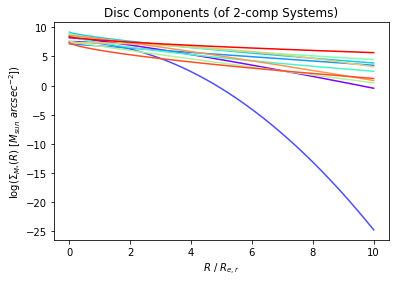

In [9]:
#Plot example stellar mass profiles:
#This shows some random sample of stellar mass profiles, as a sanity check that everything looks as we expect.
#This is only showing stellar mass profiles for disc components of two component systems.

from   matplotlib.pyplot import cm

sample = twoComp_galaxies[::70][:,0].tolist()

fig = plt.figure()

plt.title('Disc Components (of 2-comp Systems)')

clr = cm.rainbow(np.linspace(0,1,len(sample)))
for j,i in enumerate(sample):
   Re_r = mydata['reT_r_arcsec'][i] #The R range is in arcsecs, so the effective radii we normalise by, also needs to be arcsecs
   plt.plot(R['D'][i]/Re_r,logMstar_wrt_r['D'][i],color=clr[j])

plt.xlabel('$R$ / $R_{e,r}$')
plt.ylabel(r'$\log(\Sigma_{M_{*}}(R) \ [M_{sun} \ arcsec^{-2}])$')

fig.savefig(path+'Figures/ExampleMstarProfiles.pdf')

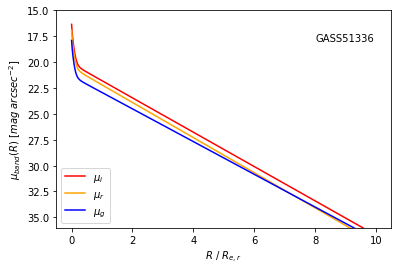

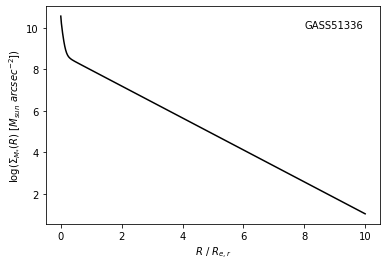

In [10]:
#Plots for 6-month review presentation:

gassid = 'GASS51336'

gal = np.argwhere(mydata['GASSID']==gassid)[0][0]

Re = mydata['reT_r_arcsec'][gal] #The R range is in arcsecs, so the effective radii we normalise by, also needs to be arcsecs

#-- Intensity Profile

#fig = plt.figure()
#
#
#
#plt.text(8,1000,gassid)
#
#plt.xlabel('$R$ / $R_{e,r}$')
#plt.ylabel(r'$I_{band}(R) \ [W.m^{-2}.Hz^{-1}.kpc^{-2}]$')
#
##plt.ylim(30.5,15)
#
#plt.yscale('log')
#    
##plt.plot(R['T'][gal]/Re,I_wrt_r['T']['i'][gal],color='r',     label='i-band')
#plt.plot(R['T'][gal]/Re,I_wrt_r['T']['r'][gal],color='orange',label='r-band')
##plt.plot(R['T'][gal]/Re,I_wrt_r['T']['g'][gal],color='b',     label='g-band')
#
#plt.legend(loc='lower left')
#
#fig.savefig(path+'Figures/'+gassid+'_IntensityProfile.png')


#-- Magnitude Surface Density

fig = plt.figure()

plt.text(8,18,gassid)

plt.xlabel('$R$ / $R_{e,r}$')
plt.ylabel(r'$\mu_{band}(R) \ [mag \ arcsec^{-2}]$')

plt.ylim(36,15)
    
plt.plot(R['T'][gal]/Re,sd['T']['i'][gal],color='r',     label='$\mu_{i}$')
plt.plot(R['T'][gal]/Re,sd['T']['r'][gal],color='orange',label='$\mu_{r}$')
plt.plot(R['T'][gal]/Re,sd['T']['g'][gal],color='b',     label='$\mu_{g}$')

#plt.fill_between([0,10],35,mydata['RMS'][gal],color='grey',alpha=0.2)
    
#plt.text(3,18,'$R_{e,r}$ = '+str(round(mydata['reD_r_kpc'][gal],2))+' [kpc] \n $n_{r}$ = '+str(round(mydata['nserD_r'][gal],2)))

plt.legend(loc='lower left')

fig.savefig(path+'Figures/'+gassid+'_MagProfile.png')

# -- Mass Profile

fig = plt.figure()

plt.plot(R['T'][gal]/Re,logMstar_wrt_r['T'][gal],color='k')

plt.text(8,10,gassid)

plt.xlabel('$R$ / $R_{e,r}$')
plt.ylabel(r'$\log(\Sigma_{M_{*}}(R) \ [M_{sun} \ arcsec^{-2}])$')

fig.savefig(path+'Figures/'+gassid+'_MassProfile.png')

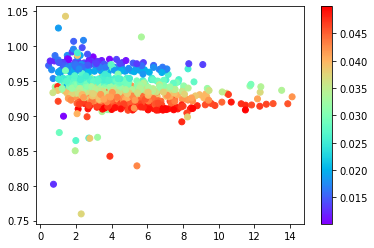

In [14]:
master_order = []
for i in range(len(master_robdata['GASSID'])): #For every id in robins data
    master_order.append(np.argwhere(mydata['GASSID'] == master_robdata['GASSID'][i])[0][0]) #find that ID in mydata and record its location

twoComp_galaxies_rob = np.argwhere(master_robdata['Model']==0)
    
z= mydata['zSDSS']
cmap = plt.cm.get_cmap('rainbow')
sc = plt.scatter(np.array(reT_kpc['r'])[order][twoComp_galaxies_rob],np.array(reT_kpc['r'])[order][twoComp_galaxies_rob]/master_robdata['reT_r_kpc'][twoComp_galaxies_rob],
            c=master_robdata['zSDSS'][twoComp_galaxies_rob],cmap = cmap)
plt.colorbar(sc)

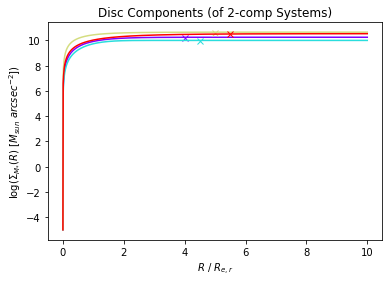

In [15]:
#Plot example stellar mass profiles:
#This shows some random sample of stellar mass profiles, as a sanity check that everything looks as we expect.
#This is only showing stellar mass profiles for disc components of two component systems.

from   matplotlib.pyplot import cm

sample = twoComp_galaxies[::200][:,0].tolist()

fig = plt.figure()

plt.title('Disc Components (of 2-comp Systems)')

clr = cm.rainbow(np.linspace(0,1,len(sample)))
for j,i in enumerate(sample):
    Re_r = mydata['reT_r_arcsec'][i] #The R range is in arcsecs, so the effective radii we normalise by, also needs to be arcsecs
    plt.plot(R['D'][i]/Re_r,logMstar_within_r['D'][i],color=clr[j])

    plt.plot([4+(j*0.5)],mydata['log10TotM*D'][i],'x',color=clr[j])
    
plt.xlabel('$R$ / $R_{e,r}$')
plt.ylabel(r'$\log(\Sigma_{M_{*}}(R) \ [M_{sun} \ arcsec^{-2}])$')

fig.savefig(path+'Figures/ExampleMstarAccumulativeProfiles.pdf')

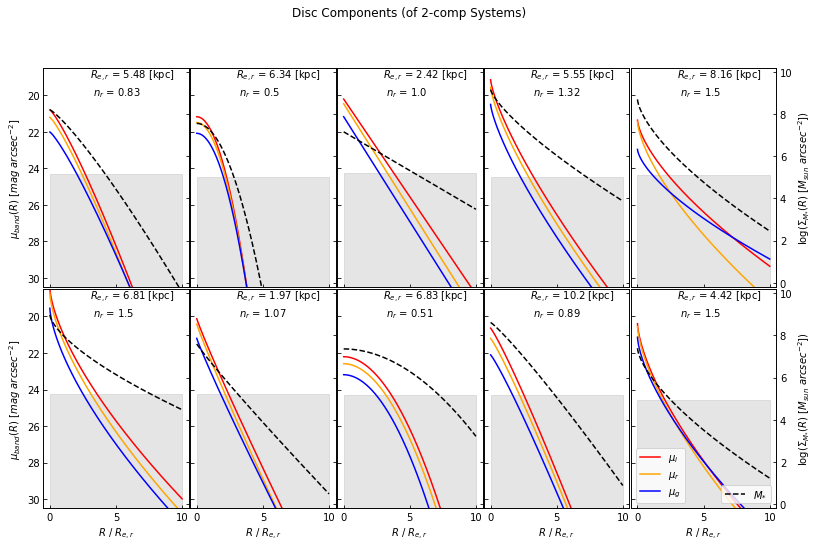

In [16]:
#This shows a sample of disc component (of 2-component system) galaxies 
#plotting surface density profiles (not corrected by a distance modulus, so analogous to apparent magnitudes)

fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(nrows=2,ncols=5,figsize=(12,8),sharex=True,sharey=True)
fig.tight_layout()
fig.subplots_adjust(wspace=0.01,hspace=0.01)
for axs in [ax6,ax7,ax8,ax9,ax10]:
   axs.set_xlabel('$R$ / $R_{e,r}$')

ax1.set_ylabel(r'$\mu_{band}(R) \ [mag \ arcsec^{-2}]$')
ax6.set_ylabel(r'$\mu_{band}(R) \ [mag \ arcsec^{-2}]$')

fig.suptitle('Disc Components (of 2-comp Systems)')

sample = twoComp_galaxies[::70]

for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]):
    ax.set_ylim(30.5,18.5)
    ax.tick_params(axis='both',direction='in')
    Re = mydata['reT_r_arcsec'][sample][i]#Because R is in arcsecs, we also need Re in arcsecs
    gal = sample[i,0]
    
    ax.plot(R['D'][gal]/Re,sd['D']['i'][gal],color='r',     label='$\mu_{i}$')
    ax.plot(R['D'][gal]/Re,sd['D']['r'][gal],color='orange',label='$\mu_{r}$')
    ax.plot(R['D'][gal]/Re,sd['D']['g'][gal],color='b',     label='$\mu_{g}$')

    ax.fill_between([0,10],35,mydata['RMS'][gal],color='grey',alpha=0.2)
    
    ax.text(3,20,'$R_{e,r}$ = '+str(round(mydata['reD_r_kpc'][gal],2))+' [kpc] \n $n_{r}$ = '+str(round(mydata['nserD_r'][gal],2)))

    axb = ax.twinx() # instantiate a second axes that shares the same x-axis

    axb.set_ylim(-0.2,10.2)
    axb.tick_params(axis='both',direction='in')
    
    axb.plot(R['D'][gal]/Re,logMstar_wrt_r['D'][gal],color='k',label='$M_{*}$',ls='--')

    if i == 4 or i == 9:
        axb.set_ylabel(r'$\log(\Sigma_{M_{*}}(R) \ [M_{sun} \ arcsec^{-2}])$')

    else:
        axb.set_yticklabels([])


ax.legend(loc='lower left')
axb.legend(loc='lower right')

fig.tight_layout(pad=3)  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(wspace=0.01,hspace=0.01)

fig.savefig(path+'Figures/Example_mu_Mstar_Profiles.pdf')

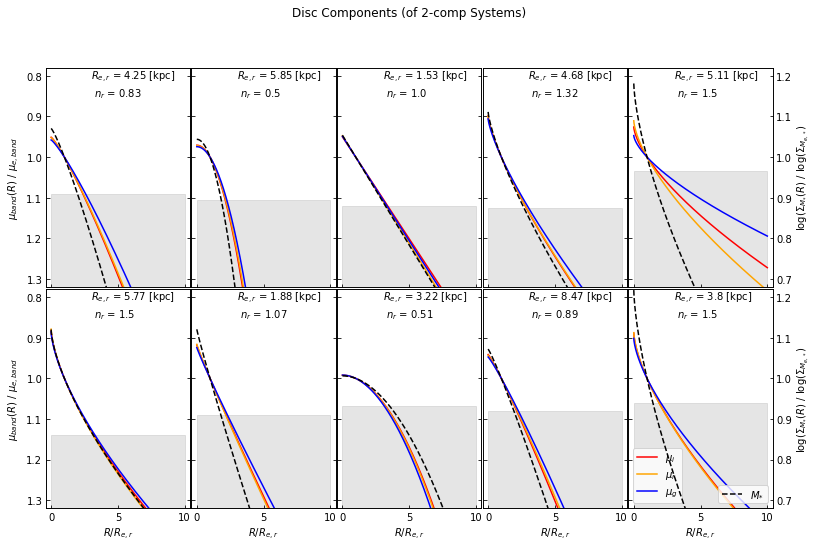

In [17]:
#This shows a sample of disc component (of 2-component system) galaxies 

fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(nrows=2,ncols=5,figsize=(12,8),sharex=True,sharey=True)
fig.tight_layout()
fig.subplots_adjust(wspace=0.01,hspace=0.01)
for axs in [ax6,ax7,ax8,ax9,ax10]:
   axs.set_xlabel('$R / R_{e,r}$')

fig.suptitle('Disc Components (of 2-comp Systems)')

sample = twoComp_galaxies[::70]

ax1.set_ylabel(r'$\mu_{band}(R) \ / \ \mu_{e,band}$')
ax6.set_ylabel(r'$\mu_{band}(R) \ / \ \mu_{e,band}$')

for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]):
    ax.set_xlim(-0.4,10.4)
    ax.set_ylim(1.32,0.78)
    ax.tick_params(axis='both',direction='in')
    
    gal = sample[i,0]
    
    Re = mydata['reT_r_arcsec'][gal] #Because R is in arcsecs, we also need Re in arcsecs
    loc_re = np.argwhere(R['D'][gal] <= Re+0.001)[-1]
    
    ax.plot(R['D'][gal]/Re,sd['D']['i'][gal]/sd['D']['i'][gal][loc_re],color='r',     label='$\mu_{i}$')
    ax.plot(R['D'][gal]/Re,sd['D']['r'][gal]/sd['D']['r'][gal][loc_re],color='orange',label='$\mu_{r}$')
    ax.plot(R['D'][gal]/Re,sd['D']['g'][gal]/sd['D']['g'][gal][loc_re],color='b',     label='$\mu_{g}$')
   
    ax.fill_between([0,10],35,mydata['RMS'][gal]/sd['D']['r'][gal][loc_re],color='grey',alpha=0.2)

    ax.text(3,0.85,'$R_{e,r}$ = '+str(round(mydata['reT_r_kpc'][gal],2))+' [kpc] \n $n_{r}$ = '+str(round(mydata['nserD_r'][gal],2)))
   
    axb = ax.twinx() # instantiate a second axes that shares the same x-axis

    axb.set_ylim(0.68,1.22)
    axb.tick_params(axis='both',direction='in')
    axb.plot(R['D'][gal]/Re,logMstar_wrt_r['D'][gal]/logMstar_wrt_r['D'][gal][loc_re],color='k',label='$M_{*}$',ls='--')
   
    if i == 4 or i == 9:
        axb.set_ylabel(r'$\log(\Sigma_{M_{*}}(R) \ / \ \log(\Sigma_{M_{e,*}})$')
   
    else:
        axb.set_yticklabels([])

ax.legend(loc='lower left')
axb.legend(loc='lower right')

fig.tight_layout(pad=3)  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(wspace=0.01,hspace=0.01)

fig.savefig(path+'Figures/Example_mu_Mstar_Profiles_normalised.pdf')

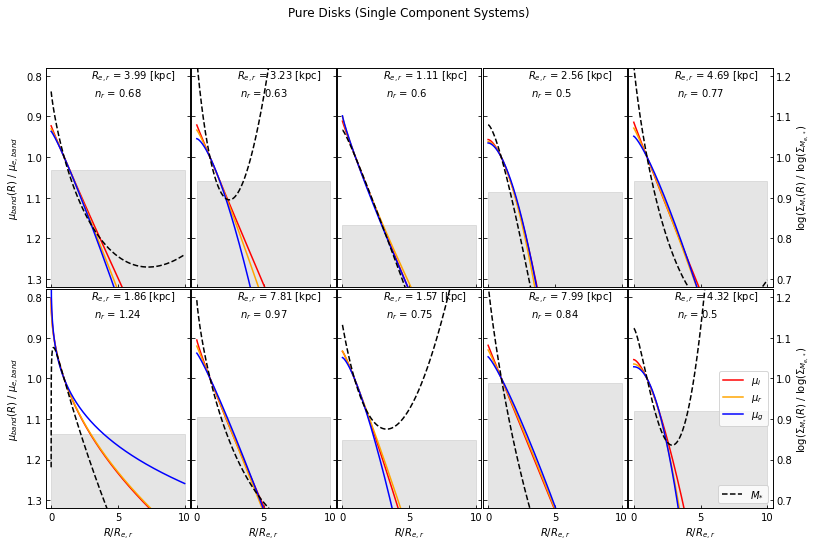

In [18]:
#This shows a sample of disc component (of 2-component system) galaxies 

fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(nrows=2,ncols=5,figsize=(12,8),sharex=True,sharey=True)
fig.tight_layout()
fig.subplots_adjust(wspace=0.01,hspace=0.01)
for axs in [ax6,ax7,ax8,ax9,ax10]:
   axs.set_xlabel('$R / R_{e,r}$')

fig.suptitle('Pure Disks (Single Component Systems)')

sample = pure_disks[::20]

ax1.set_ylabel(r'$\mu_{band}(R) \ / \ \mu_{e,band}$')
ax6.set_ylabel(r'$\mu_{band}(R) \ / \ \mu_{e,band}$')

for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]):
    ax.set_xlim(-0.4,10.4)
    ax.set_ylim(1.32,0.78)
    ax.tick_params(axis='both',direction='in')
    
    gal = sample[i,0]
    
    Re = mydata['re_r_arcsec'][gal] #Because R is in arcsecs, we also need Re in arcsecs
    loc_re = np.argwhere(R['D'][gal] <= Re+0.001)[-1]
    
    ax.plot(R[''][gal]/Re,sd['']['i'][gal]/sd['']['i'][gal][loc_re],color='r',     label='$\mu_{i}$')
    ax.plot(R[''][gal]/Re,sd['']['r'][gal]/sd['']['r'][gal][loc_re],color='orange',label='$\mu_{r}$')
    ax.plot(R[''][gal]/Re,sd['']['g'][gal]/sd['']['g'][gal][loc_re],color='b',     label='$\mu_{g}$')
   
    ax.fill_between([0,10],35,mydata['RMS'][gal]/sd['']['r'][gal][loc_re],color='grey',alpha=0.2)

    ax.text(3,0.85,'$R_{e,r}$ = '+str(round(mydata['re_r_kpc'][gal],2))+' [kpc] \n $n_{r}$ = '+str(round(mydata['nserD_r'][gal],2)))
   
    axb = ax.twinx() # instantiate a second axes that shares the same x-axis

    axb.set_ylim(0.68,1.22)
    axb.tick_params(axis='both',direction='in')
    axb.plot(R[''][gal]/Re,logMstar_wrt_r[''][gal]/logMstar_wrt_r[''][gal][loc_re],color='k',label='$M_{*}$',ls='--')
   
    if i == 4 or i == 9:
        axb.set_ylabel(r'$\log(\Sigma_{M_{*}}(R) \ / \ \log(\Sigma_{M_{e,*}})$')
   
    else:
        axb.set_yticklabels([])

ax.legend(loc='center right')
axb.legend(loc='lower right')

fig.tight_layout(pad=3)  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(wspace=0.01,hspace=0.01)

fig.savefig(path+'Figures/Example_PureDisk_mu_Mstar_Profiles_normalised.pdf')

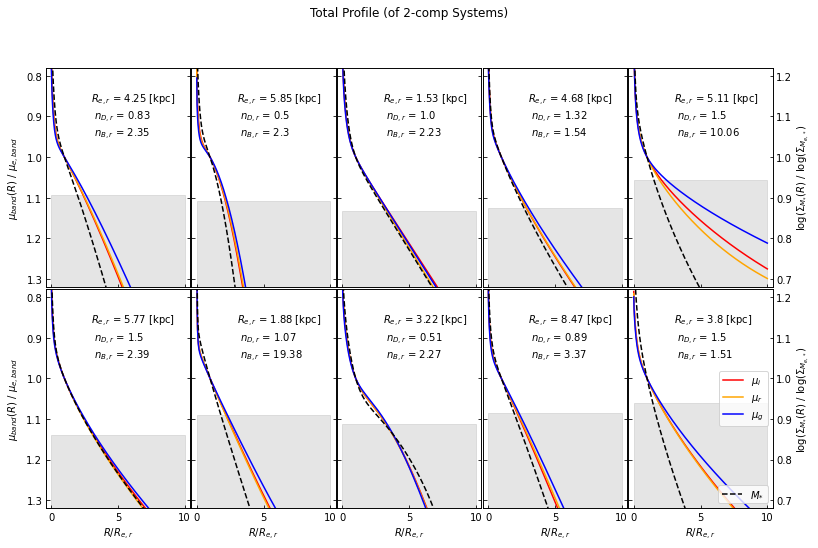

In [19]:
#This shows a sample of disc component (of 2-component system) galaxies 

fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(nrows=2,ncols=5,figsize=(12,8),sharex=True,sharey=True)
fig.tight_layout()
fig.subplots_adjust(wspace=0.01,hspace=0.01)
for axs in [ax6,ax7,ax8,ax9,ax10]:
   axs.set_xlabel('$R / R_{e,r}$')

fig.suptitle('Total Profile (of 2-comp Systems)')

sample = twoComp_galaxies[::70]

ax1.set_ylabel(r'$\mu_{band}(R) \ / \ \mu_{e,band}$')
ax6.set_ylabel(r'$\mu_{band}(R) \ / \ \mu_{e,band}$')

for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]):
    ax.set_xlim(-0.4,10.4)
    ax.set_ylim(1.32,0.78)
    ax.tick_params(axis='both',direction='in')
    
    gal = sample[i,0]
    
    Re = mydata['reT_r_arcsec'][gal] #Because R is in arcsecs, we also need Re in arcsecs
    loc_re = np.argwhere(R['D'][gal] <= Re+0.001)[-1]
    
    ax.plot(R['T'][gal]/Re,sd['T']['i'][gal]/sd['T']['i'][gal][loc_re],color='r',     label='$\mu_{i}$')
    ax.plot(R['T'][gal]/Re,sd['T']['r'][gal]/sd['T']['r'][gal][loc_re],color='orange',label='$\mu_{r}$')
    ax.plot(R['T'][gal]/Re,sd['T']['g'][gal]/sd['T']['g'][gal][loc_re],color='b',     label='$\mu_{g}$')
   
    ax.fill_between([0,10],35,mydata['RMS'][gal]/sd['T']['r'][gal][loc_re],color='grey',alpha=0.2)

    ax.text(3,0.95,
            '$R_{e,r}$ = '+str(round(mydata['reT_r_kpc'][gal],2))+' [kpc] \n $n_{D,r}$ = '+str(round(mydata['nserD_r'][gal],2))+'\n $n_{B,r}$ = '+str(round(mydata['nserB_r'][gal],2)))
   
    axb = ax.twinx() # instantiate a second axes that shares the same x-axis

    axb.set_ylim(0.68,1.22)
    axb.tick_params(axis='both',direction='in')
    axb.plot(R['T'][gal]/Re,logMstar_wrt_r['T'][gal]/logMstar_wrt_r['T'][gal][loc_re],color='k',label='$M_{*}$',ls='--')
   
    if i == 4 or i == 9:
        axb.set_ylabel(r'$\log(\Sigma_{M_{*}}(R) \ / \ \log(\Sigma_{M_{e,*}})$')
   
    else:
        axb.set_yticklabels([])

ax.legend(loc='center right')
axb.legend(loc='lower right')

fig.tight_layout(pad=3)  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(wspace=0.01,hspace=0.01)

fig.savefig(path+'Figures/Example_Total_mu_Mstar_Profiles_normalised.pdf')

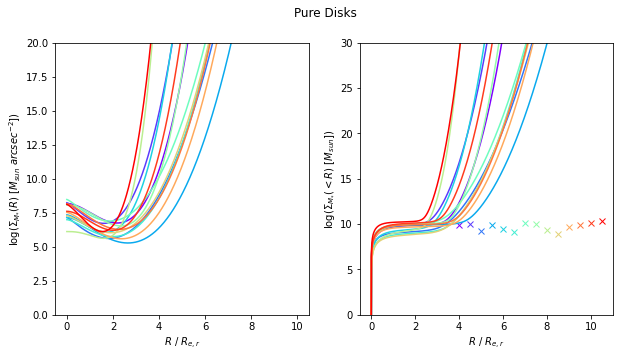

In [20]:
#Plot example stellar mass profiles:
#This shows some random sample of stellar mass profiles, as a sanity check that everything looks as we expect.
#This is only showing stellar mass profiles for disc components of two component systems.

from   matplotlib.pyplot import cm

sample_index = np.argwhere(TotMstar_recover[''][pure_disks]>50)[:,0].tolist()
sample = pure_disks[sample_index][:,0].tolist()

fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2,figsize=(10,5))

fig.suptitle('Pure Disks')

clr = cm.rainbow(np.linspace(0,1,len(sample)))
for j,i in enumerate(sample):
    Re_r = mydata['re_r_arcsec'][i] #The R range is in arcsecs, so the effective radii we normalise by, also needs to be arcsecs
    ax1.plot(np.array(R[''][i])/np.array(Re_r),logMstar_wrt_r[''][i],color=clr[j])
    
    ax2.plot(np.array(R[''][i])/np.array(Re_r),logMstar_within_r[''][i],color=clr[j])

    ax2.plot([4+(j*0.5)],mydata['log10TotM*'][i],'x',color=clr[j])

ax1.set_ylim(0,20)
    
ax1.set_xlabel('$R$ / $R_{e,r}$')
ax1.set_ylabel(r'$\log(\Sigma_{M_{*}}(R) \ [M_{sun} \ arcsec^{-2}])$')
    
ax2.set_ylim(0,30)
    
ax2.set_xlabel('$R$ / $R_{e,r}$')
ax2.set_ylabel(r'$\log(\Sigma_{M_{*}}(< R) \ [M_{sun}])$')

fig.savefig(path+'Figures/ExampleMstarPureDiskAccumulativeProfiles.pdf')

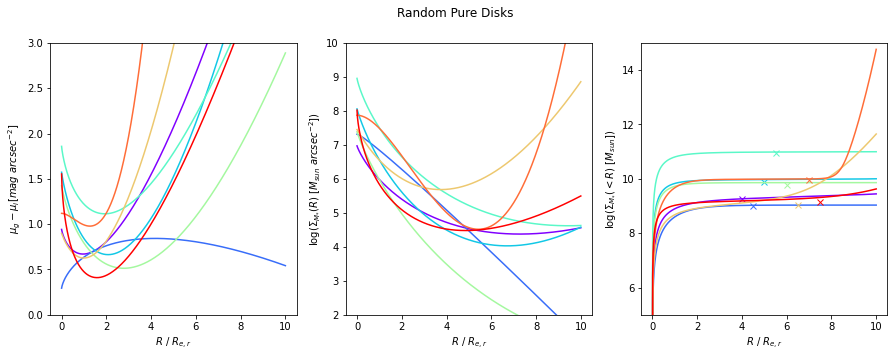

In [21]:
#Plot example stellar mass profiles:
#This shows some random sample of stellar mass profiles, as a sanity check that everything looks as we expect.

from   matplotlib.pyplot import cm

sample = pure_disks[::40,0].tolist()

fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3,figsize=(15,5))

fig.suptitle('Random Pure Disks')

clr = cm.rainbow(np.linspace(0,1,len(sample)))
for j,i in enumerate(sample):
    Re_r = mydata['re_r_arcsec'][i] #The R range is in arcsecs, so the effective radii we normalise by, also needs to be arcsecs
    ax1.plot(R[''][i]/Re_r,sd['']['g'][i] - sd['']['i'][i],color=clr[j])
    ax2.plot(np.array(R[''][i])/np.array(Re_r),logMstar_wrt_r[''][i],color=clr[j])
    
    ax3.plot(np.array(R[''][i])/np.array(Re_r),logMstar_within_r[''][i],color=clr[j])

    ax3.plot([4+(j*0.5)],mydata['log10TotM*'][i],'x',color=clr[j])

ax1.set_ylim(0,3)
ax2.set_ylim(2,10) 
ax3.set_ylim(5,15)
    
ax1.set_xlabel('$R$ / $R_{e,r}$')
ax1.set_ylabel(r'$\mu_{g} - \mu_{i} [mag \ arcsec^{-2}]$')
     
ax2.set_xlabel('$R$ / $R_{e,r}$')
ax2.set_ylabel(r'$\log(\Sigma_{M_{*}}(R) \ [M_{sun} \ arcsec^{-2}])$')
    
ax3.set_xlabel('$R$ / $R_{e,r}$')
ax3.set_ylabel(r'$\log(\Sigma_{M_{*}}(< R) \ [M_{sun}])$')

fig.savefig(path+'Figures/ExampleMstarAccumulativeProfiles_RandomPureDisks.pdf')

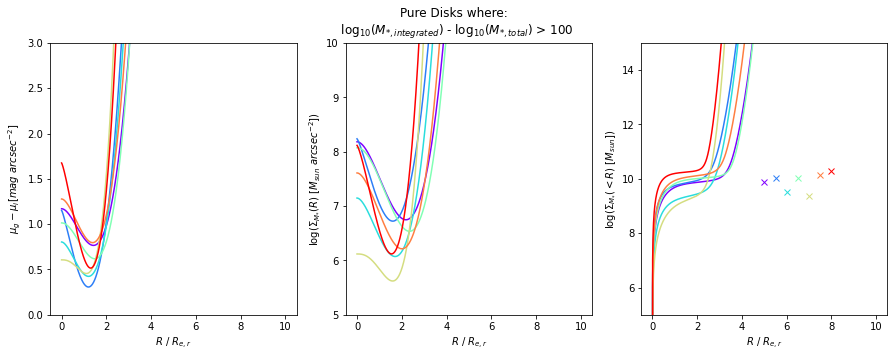

In [22]:
#Plot example stellar mass profiles:
#This shows some random sample of stellar mass profiles, as a sanity check that everything looks as we expect.
#This is only showing stellar mass profiles for disc components of two component systems.

from   matplotlib.pyplot import cm

sample_index = np.argwhere(TotMstar_recover[''][pure_disks]>100)[:,0].tolist()
sample = pure_disks[sample_index][:,0].tolist()

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

fig.suptitle('Pure Disks where: \n $\log_{10} (M_{*,integrated})$ - $\log_{10} (M_{*,total})$ > 100')

clr = cm.rainbow(np.linspace(0,1,len(sample)))
for j,i in enumerate(sample):
    Re_r = mydata['re_r_arcsec'][i] #The R range is in arcsecs, so the effective radii we normalise by, also needs to be arcsecs
    ax1.plot(R[''][i]/Re_r,sd['']['g'][i] - sd['']['i'][i],color=clr[j])

    ax2.plot(R[''][i]/Re_r,logMstar_wrt_r[''][i],color=clr[j])
    
    ax3.plot(np.array(R[''][i])/np.array(Re_r),logMstar_within_r[''][i],color=clr[j])
    ax3.plot([5+(j*0.5)],mydata['log10TotM*'][i],'x',color=clr[j])

ax1.set_ylim(0,3)
ax2.set_ylim(5,10) 
ax3.set_ylim(5,15)
    
ax1.set_xlabel('$R$ / $R_{e,r}$')
ax1.set_ylabel(r'$\mu_{g} - \mu_{i} [mag \ arcsec^{-2}]$')
    
ax2.set_xlabel('$R$ / $R_{e,r}$')
ax2.set_ylabel(r'$\log(\Sigma_{M_{*}}(R) \ [M_{sun} \ arcsec^{-2}])$')

ax3.set_xlabel('$R$ / $R_{e,r}$')
ax3.set_ylabel(r'$\log(\Sigma_{M_{*}}(< R) \ [M_{sun}])$')

fig.savefig(path+'Figures/ExampleBadMstarProfiles_PureDisk.pdf')

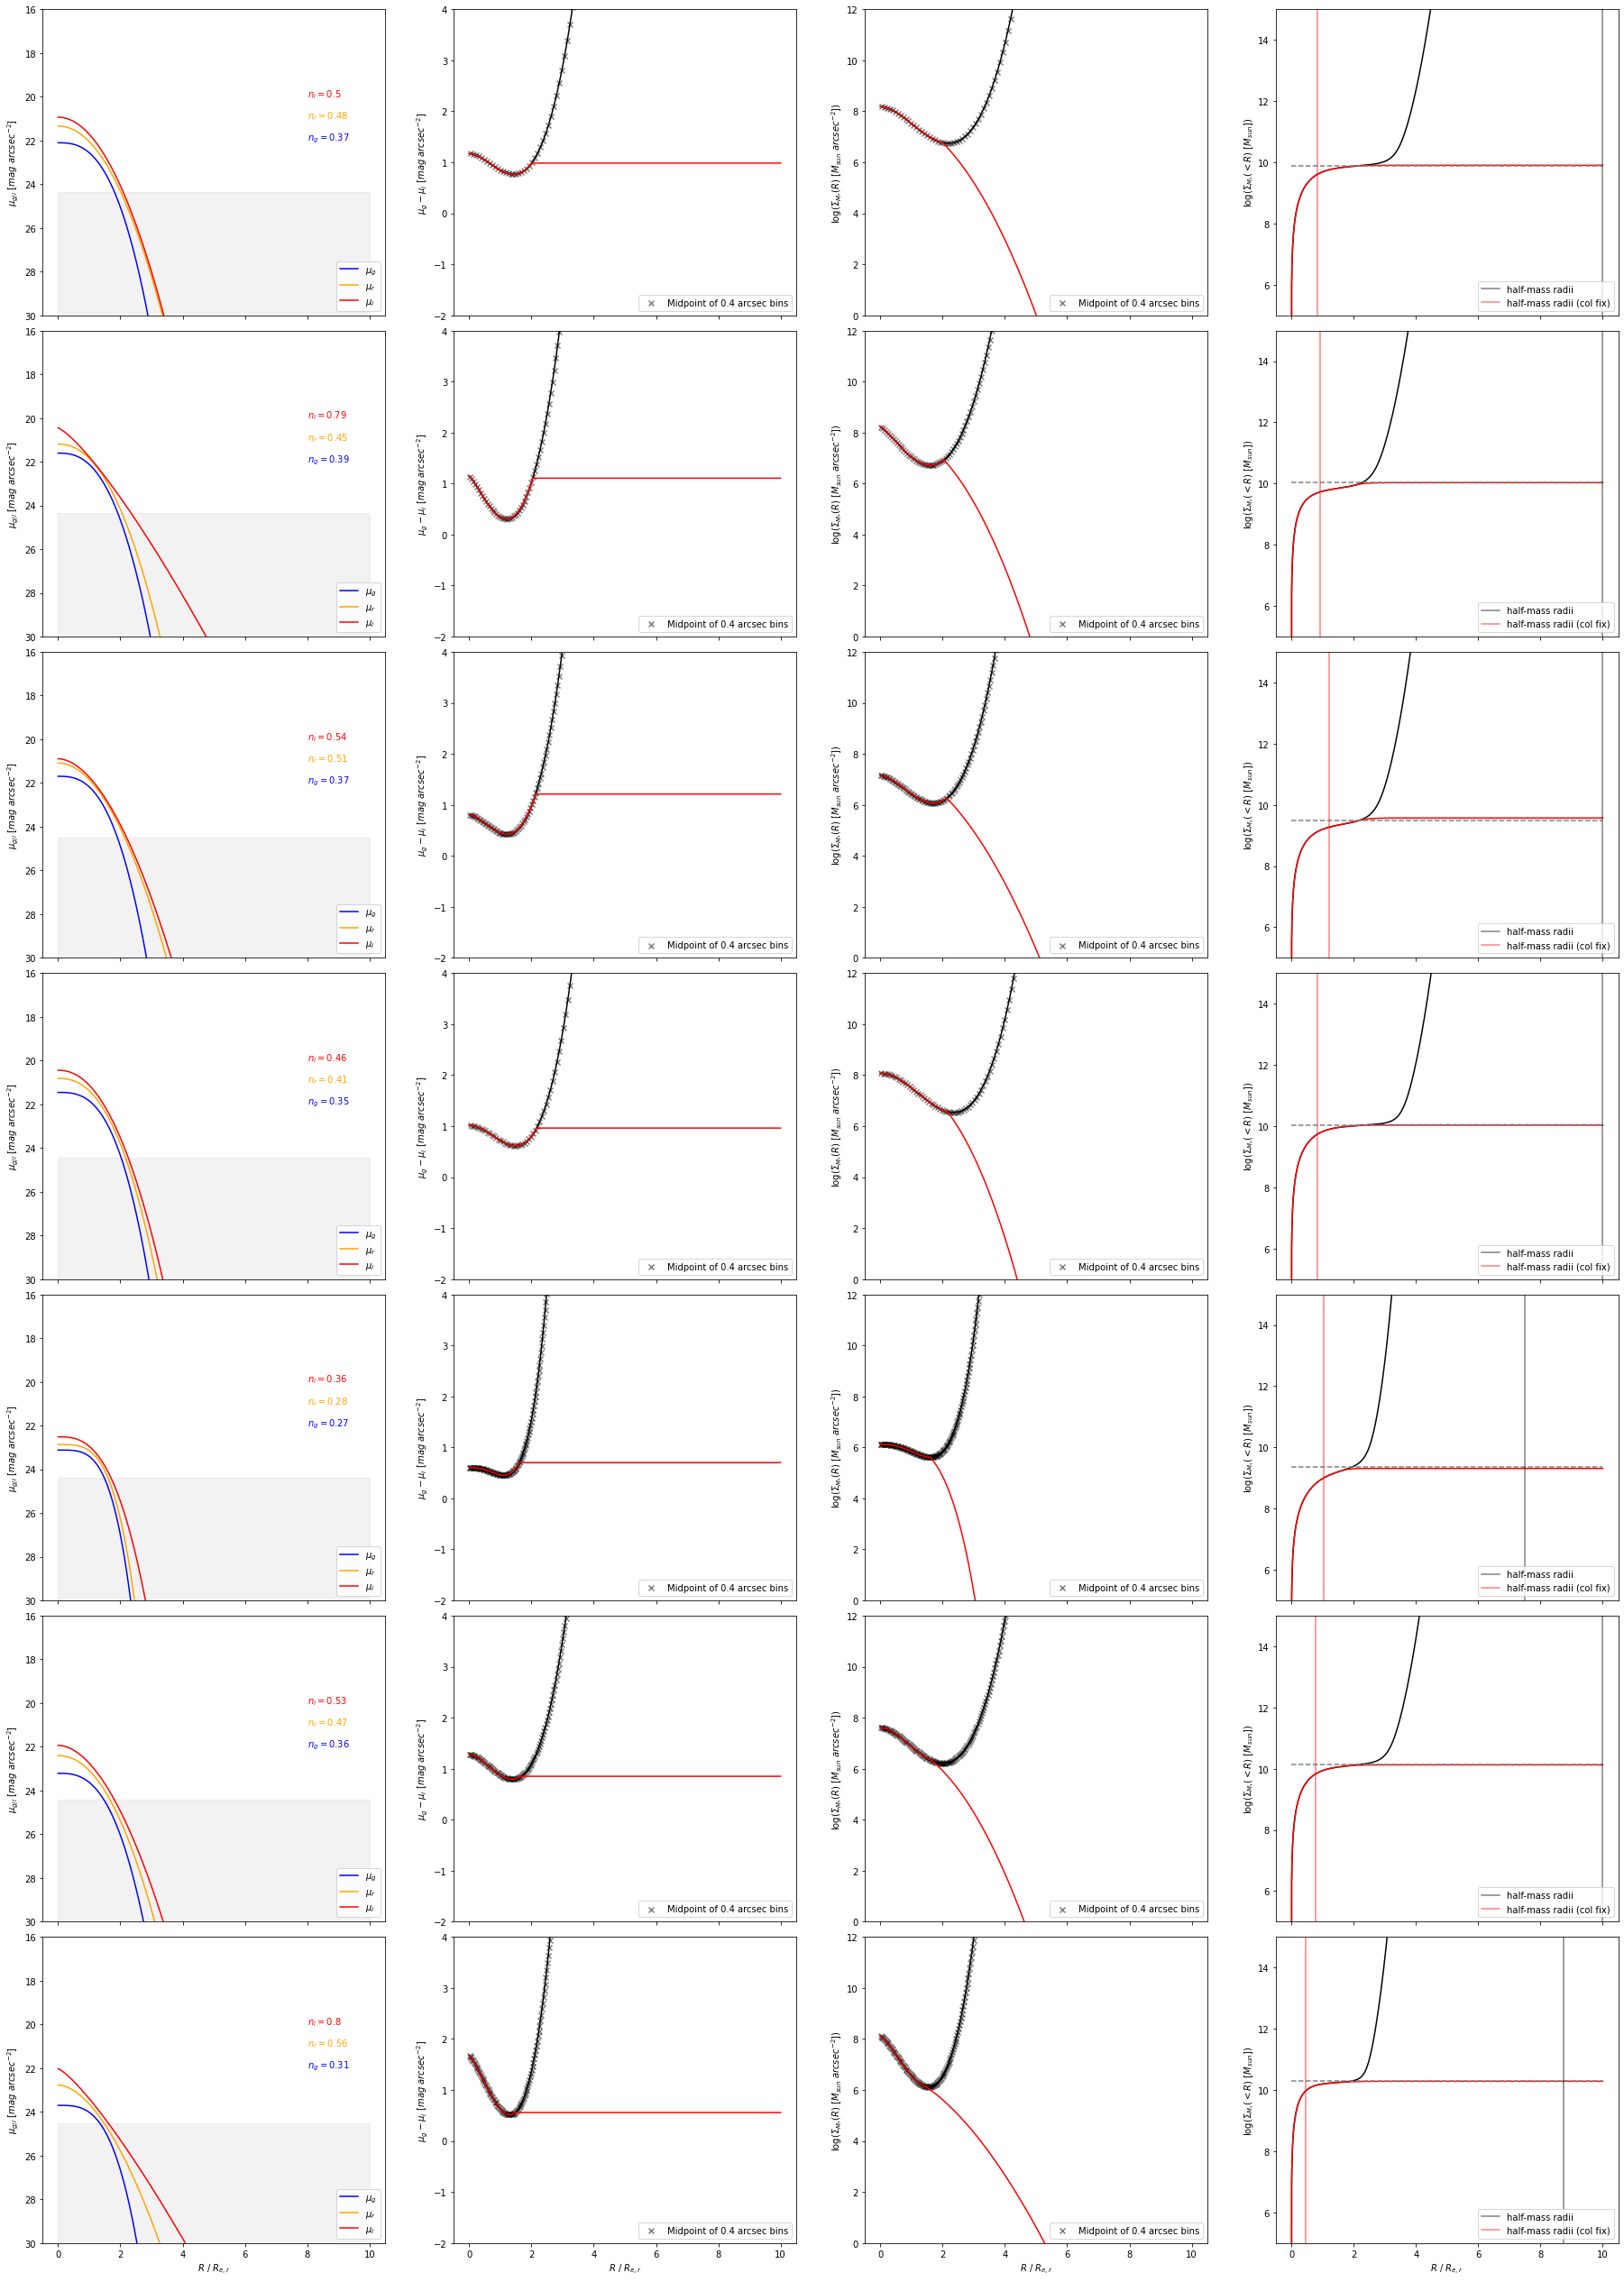

In [23]:
from   matplotlib.pyplot import cm

sample_index = np.argwhere(TotMstar_recover[''][pure_disks]>100)[:,0].tolist()
sample = pure_disks[sample_index][:,0].tolist()

fig, ax = plt.subplots(nrows=7,ncols=4,figsize=(25,35),sharex=True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.2,hspace=0.05)

#fig.suptitle('Pure Disks where: \n $\log_{10} (M_{*,integrated})$ - $\log_{10} (M_{*,total})$ > 100')

for j,i in enumerate(sample):
    Re_r = mydata['re_r_arcsec'][i] #The R range is in arcsecs, so the effective radii we normalise by, also needs to be arcsecs
    
    #--
    
    ax[j,0].plot(R[''][i]/Re_r,sd['']['g'][i],color='b',     label='$\mu_{g}$')
    ax[j,0].plot(R[''][i]/Re_r,sd['']['r'][i],color='orange',label='$\mu_{r}$')
    ax[j,0].plot(R[''][i]/Re_r,sd['']['i'][i],color='r',     label='$\mu_{i}$')
    ax[j,0].fill_between([0,10],mydata['RMS'][i],100,color='grey',alpha=0.1)
    
    ax[j,0].text(8,22,  '$n_{g} = $'+str(round(mydata['nser_g'][i],2)),color='b')
    ax[j,0].text(8,21,'$n_{r} = $'+str(round(mydata['nser_r'][i],2)),color='orange')
    ax[j,0].text(8,20,  '$n_{i} = $'+str(round(mydata['nser_i'][i],2)),color='r')
    
    #--
    
    g_i_col = sd['']['g'][i] - sd['']['i'][i]
    
    ax[j,1].plot(R[''][i]/Re_r,g_i_col,color='k')
    ax[j,1].plot(R[''][i]/Re_r,g_i_colour_fix[''][i],color='r')
    
    #We want to interpolate our data into bins of width 0.4 pixels. 
    #If I create a list of radii in steps of 0.2 bins, and use every second value, this is the midpoints of the bins.
    new_bins = np.arange(0,R[''][i][-1],step=0.2)[1::2]
    new_g_i_col = np.interp(new_bins,R[''][i],g_i_col)
    
    ax[j,1].scatter(new_bins/Re_r,new_g_i_col,color='k',marker='x',alpha=0.5,label='Midpoint of 0.4 arcsec bins')

    #--
    
    ax[j,2].plot(R[''][i]/Re_r,logMstar_wrt_r[''][i],color='k')
    ax[j,2].plot(R[''][i]/Re_r,logMstar_wrt_r_fix[''][i],color='r')
    
    new_logMstar = np.interp(new_bins,R[''][i],logMstar_wrt_r[''][i])
    
    ax[j,2].scatter(new_bins/Re_r,new_logMstar,color='k',marker='x',alpha=0.5,label='Midpoint of 0.4 arcsec bins')

    #--
    
    ax[j,3].plot(np.array(R[''][i])/np.array(Re_r),logMstar_within_r[''][i],color='k')
    ax[j,3].plot(np.array(R[''][i])/np.array(Re_r),logMstar_within_r_fix[''][i],color='r')
    
    ax[j,3].plot([0,10],[mydata['log10TotM*'][i],mydata['log10TotM*'][i]],'--',color='grey')
    
    ax[j,3].axvline(mydata['rm_arcsec'][i]/Re_r,color='k',alpha=0.5,label='half-mass radii')
    ax[j,3].axvline(mydata['rm_arcsec_fix'][i]/Re_r,color='r',alpha=0.5,label='half-mass radii (col fix)')

for row in range(7):
    ax[row,0].legend(loc = 'lower right')
    ax[row,1].legend(loc = 'lower right')
    ax[row,2].legend(loc = 'lower right')
    ax[row,3].legend(loc = 'lower right')
    
    ax[row,0].set_ylim(30,16)
    ax[row,1].set_ylim(-2,4)
    ax[row,2].set_ylim(0,12) 
    ax[row,3].set_ylim(5,15)
    
    ax[row,0].set_ylabel(r'$\mu_{g / i} \ [mag \ arcsec^{-2}]$')
    ax[row,1].set_ylabel(r'$\mu_{g} - \mu_{i} \ [mag \ arcsec^{-2}]$')
    ax[row,2].set_ylabel(r'$\log(\Sigma_{M_{*}}(R) \ [M_{sun} \ arcsec^{-2}])$')
    ax[row,3].set_ylabel(r'$\log(\Sigma_{M_{*}}(< R) \ [M_{sun}])$')
    
    
for column in range(4):
    ax[6,column].set_xlabel('$R$ / $R_{e,r}$')


fig.savefig(path+'Figures/ExampleBadMstarProfiles_PureDisk_Expanded.pdf')

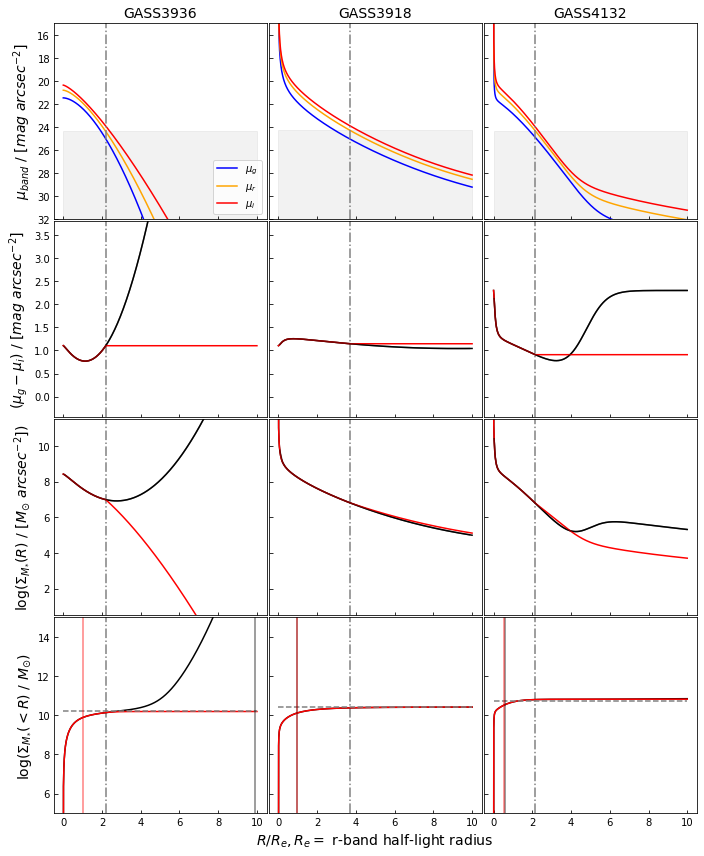

In [68]:
gass_ids = ['GASS3936','GASS3918','GASS4132']
sample = []
for g in gass_ids:
    sample.append(np.argwhere(mydata['GASSID']==g)[0][0])
    
fig, ax = plt.subplots(nrows=4,ncols=3,figsize=(10,12),sharex=True)
    
for j,i in enumerate(sample):

    col = j

    #-- which model is this galaxy?
    if mydata['Model'][i] == 0:
        comp = 'T'
    elif mydata['Model'][i] == 1:
        comp = ''
    elif mydata['Model'][i] == 2:
        comp = ''
    else:
        print('Error: model number not recognised')
        break

    #--Start Plotting Profiles    
    Re_r = mydata['re'+comp+'_r_arcsec'][i] #The R range is in arcsecs, so the effective radii we normalise by, also needs to be arcsecs

    ax[0,col].plot(R[comp][i]/Re_r,sd[comp]['g'][i],color='b',     label='$\mu_{g}$')
    ax[0,col].plot(R[comp][i]/Re_r,sd[comp]['r'][i],color='orange',label='$\mu_{r}$')
    ax[0,col].plot(R[comp][i]/Re_r,sd[comp]['i'][i],color='r',     label='$\mu_{i}$')
    ax[0,col].fill_between([0,10],mydata['RMS'][i],100,color='grey',alpha=0.1)

    loc_extra = np.argwhere(sd[comp]['r'][i] < mydata['RMS'][i])[-1]

    ax[0,col].axvline((R[comp][i]/Re_r)[loc_extra],0,1,color='grey',ls='-.')
    ax[1,col].axvline((R[comp][i]/Re_r)[loc_extra],0,1,color='grey',ls='-.')
    ax[2,col].axvline((R[comp][i]/Re_r)[loc_extra],0,1,color='grey',ls='-.')
    ax[3,col].axvline((R[comp][i]/Re_r)[loc_extra],0,1,color='grey',ls='-.')

    ax[0,col].set_title(str(mydata['GASSID'][i]),fontsize=14)#+'\n Model: '+str(mydata['Model'][i]))

    #--

    g_i_col = sd[comp]['g'][i] - sd[comp]['i'][i]
    ax[1,col].plot(R[comp][i]/Re_r,g_i_col,color='k')

    ax[1,col].plot(R[comp][i]/Re_r,g_i_colour_fix[comp][i],color='r')

    #We want to interpolate our data into bins of width 0.4 pixels. 
    #If I create a list of radii in steps of 0.2 bins, and use every second value, this is the midpoints of the bins.
    new_bins = np.arange(0,R[comp][i][-1],step=0.2)[1::2]
    new_g_i_col = np.interp(new_bins,R[comp][i],g_i_col)
    ax[1,col].plot(new_bins/Re_r,new_g_i_col,color='k',alpha=0.5)#,label='Midpoint of 0.4 arcsec bins')#,marker='x'

    #--

    ax[2,col].plot(R[comp][i]/Re_r,logMstar_wrt_r[comp][i],color='k')

    ax[2,col].plot(R[comp][i]/Re_r,logMstar_wrt_r_fix[comp][i],color='r')

    new_logMstar = np.interp(new_bins,R[comp][i],logMstar_wrt_r[comp][i])
    ax[2,col].plot(new_bins/Re_r,new_logMstar,color='k',alpha=0.5)#,label='Midpoint of 0.4 arcsec bins')#,marker='x'

    #--

    ax[3,col].plot(np.array(R[comp][i])/np.array(Re_r),logMstar_within_r[comp][i],color='k')

    ax[3,col].plot(np.array(R[comp][i])/np.array(Re_r),logMstar_within_r_fix[comp][i],color='r')

    ax[3,col].plot([0,10],[mydata['log10TotM*'+comp][i],mydata['log10TotM*'+comp][i]],'--',color='grey')

    ax[3,col].axvline(mydata['rm'+comp+'_arcsec'][i]/Re_r,color='k',alpha=0.5,label='half-mass radii')
    ax[3,col].axvline(mydata['rm'+comp+'_arcsec_fix'][i]/Re_r,color='r',alpha=0.5,label='half-mass radii (col fix)')

    #-- Style features
    
    ax[0,col].set_ylim(32,15)
    ax[1,col].set_ylim(-0.45,3.8)
    ax[2,col].set_ylim(0.5,11.5) 
    ax[3,col].set_ylim(5,15)
    
    if col!= 0:
        for row in (0,1,2,3):
            ax[row,col].set_yticklabels([])

ax[0,0].legend(loc = 'lower right')
#ax[1,0].legend(loc = 'lower right')
#ax[2,0].legend(loc = 'lower right')
#ax[3,0].legend(loc = 'lower right')

#ax[3,0].set_xlabel('R/R_{e}, R_{e} = r-band half-light radius',fontsize=14)
ax[3,1].set_xlabel('$R/R_{e}, R_{e} =$ r-band half-light radius',fontsize=14)
#ax[3,2].set_xlabel('R/R_{e}, R_{e} = r-band half-light radius',fontsize=14)
    
ax[0,0].set_ylabel(r'$\mu_{band} \ / \ [mag \ arcsec^{-2}]$',fontsize=14)
ax[1,0].set_ylabel(r'$(\mu_{g} - \mu_{i}) \ / \ [mag \ arcsec^{-2}]$',fontsize=14)
ax[2,0].set_ylabel(r'$\log(\Sigma_{M_{*}}(R) \ / \ [M_{\odot} \ arcsec^{-2}])$',fontsize=14)
ax[3,0].set_ylabel(r'$\log(\Sigma_{M_{*}}(< R) \ / \ M_{\odot})$',fontsize=14)

for axes in ax.flatten():
    axes.tick_params(direction='in')
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.01,hspace=0.01)

fig.savefig('/home/jenniferhardwick/Insync/21514305@student.uwa.edu.au/OneDrive Biz/PhD/Thesis_Files/ColourProfiles.pdf')

In [ ]:
# Create the PdfPages object to which we will save the pages:
# The with statement makes sure that the PdfPages object is closed properly at
# the end of the block, even if an Exception occurs.
with PdfPages(path+'Figures/AllProfiles_AllGalaxies.pdf') as pdf:
    
    sample = np.argwhere(mydata['Model']!=-1)[:,0].tolist()
    num_gal = len(sample)

    num_pages = math.ceil(num_gal/7) #I only want 7 plots per page, so this defines how many pages there are...
    page = 0 #haven't started any pages yet...
    
    for j,i in enumerate(sample):
        
        #-- Defining pages
        if j%7==0: #Need to start a new page 
            page += 1
            row = 0
            
            print('Starting page ',page,' out of ',str(int(num_pages+1)))
    
            if page != 1:#If its not the first page, then the page before needs an x-axis
                for column in range(4):
                    ax[6,column].set_xlabel('$R$ / $R_{e,r}$')
                
                fig.tight_layout()
                pdf.savefig()  # saves the current figure into a pdf page
                plt.close()    #Close this so another page can be created

            fig, ax = plt.subplots(nrows=7,ncols=4,figsize=(25,35),sharex=True)
            fig.subplots_adjust(wspace=0.2,hspace=0.05)
        else:
            row +=1
            
        #-- which model is this galaxy?
        if mydata['Model'][i] == 0:
            comp = 'T'
        elif mydata['Model'][i] == 1:
            comp = ''
        elif mydata['Model'][i] == 2:
            comp = ''
        else:
            print('Error: model number not recognised')
            break
            
        #--Start Plotting Profiles    
        Re_r = mydata['re'+comp+'_r_arcsec'][i] #The R range is in arcsecs, so the effective radii we normalise by, also needs to be arcsecs
    
        ax[row,0].plot(R[comp][i]/Re_r,sd[comp]['g'][i],color='b',     label='$\mu_{g}$')
        ax[row,0].plot(R[comp][i]/Re_r,sd[comp]['r'][i],color='orange',label='$\mu_{r}$')
        ax[row,0].plot(R[comp][i]/Re_r,sd[comp]['i'][i],color='r',     label='$\mu_{i}$')
        ax[row,0].fill_between([0,10],mydata['RMS'][i],100,color='grey',alpha=0.1)
        
        loc_extra = np.argwhere(sd[comp]['r'][i] < mydata['RMS'][i])[-1]
        
        ax[row,0].axvline((R[comp][i]/Re_r)[loc_extra],0,1,color='grey',ls='-.')
        ax[row,1].axvline((R[comp][i]/Re_r)[loc_extra],0,1,color='grey',ls='-.')
        ax[row,2].axvline((R[comp][i]/Re_r)[loc_extra],0,1,color='grey',ls='-.')
        ax[row,3].axvline((R[comp][i]/Re_r)[loc_extra],0,1,color='grey',ls='-.')

        ax[row,0].text(8,20,str(mydata['GASSID'][i])+'\n Model: '+str(mydata['Model'][i]))

        #--
        
        g_i_col = sd[comp]['g'][i] - sd[comp]['i'][i]
        ax[row,1].plot(R[comp][i]/Re_r,g_i_col,color='k')
        
        ax[row,1].plot(R[comp][i]/Re_r,g_i_colour_fix[comp][i],color='r')
        
        #We want to interpolate our data into bins of width 0.4 pixels. 
        #If I create a list of radii in steps of 0.2 bins, and use every second value, this is the midpoints of the bins.
        new_bins = np.arange(0,R[comp][i][-1],step=0.2)[1::2]
        new_g_i_col = np.interp(new_bins,R[comp][i],g_i_col)
        ax[row,1].scatter(new_bins/Re_r,new_g_i_col,color='k',marker='x',alpha=0.5,label='Midpoint of 0.4 arcsec bins')

        #--
        
        ax[row,2].plot(R[comp][i]/Re_r,logMstar_wrt_r[comp][i],color='k')
        
        ax[row,2].plot(R[comp][i]/Re_r,logMstar_wrt_r_fix[comp][i],color='r')
        
        new_logMstar = np.interp(new_bins,R[comp][i],logMstar_wrt_r[comp][i])
        ax[row,2].scatter(new_bins/Re_r,new_logMstar,color='k',marker='x',alpha=0.5,label='Midpoint of 0.4 arcsec bins')

        #--
        
        ax[row,3].plot(np.array(R[comp][i])/np.array(Re_r),logMstar_within_r[comp][i],color='k')
        
        ax[row,3].plot(np.array(R[comp][i])/np.array(Re_r),logMstar_within_r_fix[comp][i],color='r')
        
        ax[row,3].plot([0,10],[mydata['log10TotM*'+comp][i],mydata['log10TotM*'+comp][i]],'--',color='grey')
        
        ax[row,3].axvline(mydata['rm'+comp+'_arcsec'][i]/Re_r,color='k',alpha=0.5,label='half-mass radii')
        ax[row,3].axvline(mydata['rm'+comp+'_arcsec_fix'][i]/Re_r,color='r',alpha=0.5,label='half-mass radii (col fix)')

        #-- Style features

        ax[row,0].legend(loc = 'lower right')
        ax[row,1].legend(loc = 'lower right')
        ax[row,2].legend(loc = 'lower right')
        ax[row,3].legend(loc = 'lower right')

        ax[row,0].set_ylim(30,16)
        ax[row,1].set_ylim(-2,4)
        ax[row,2].set_ylim(0,12) 
        ax[row,3].set_ylim(5,15)

        ax[row,0].set_ylabel(r'$\mu_{band} \ [mag \ arcsec^{-2}]$')
        ax[row,1].set_ylabel(r'$\mu_{g} - \mu_{i} \ [mag \ arcsec^{-2}]$')
        ax[row,2].set_ylabel(r'$\log(\Sigma_{M_{*}}(R) \ [M_{sun} \ arcsec^{-2}])$')
        ax[row,3].set_ylabel(r'$\log(\Sigma_{M_{*}}(< R) \ [M_{sun}])$')

        if i == sample[-1]:
            #Then the last galaxy has been plotted and we need to close the last page:
            for column in range(4):
                ax[6,column].set_xlabel('$R$ / $R_{e,r}$')

            fig.tight_layout()
            pdf.savefig()  # saves the current figure into a pdf page
            plt.close()    #Close this so another page can be created

print('DONE :D')

Starting page  1  out of  155
Starting page  2  out of  155
Starting page  3  out of  155
Starting page  4  out of  155
Starting page  5  out of  155
Starting page  6  out of  155
Starting page  7  out of  155
Starting page  8  out of  155
Starting page  9  out of  155
Starting page  10  out of  155
Starting page  11  out of  155
Starting page  12  out of  155
Starting page  13  out of  155
Starting page  14  out of  155
Starting page  15  out of  155
Starting page  16  out of  155
Starting page  17  out of  155
Starting page  18  out of  155
Starting page  19  out of  155
Starting page  20  out of  155
Starting page  21  out of  155
Starting page  22  out of  155
Starting page  23  out of  155
Starting page  24  out of  155
Starting page  25  out of  155
Starting page  26  out of  155
Starting page  27  out of  155
Starting page  28  out of  155
Starting page  29  out of  155
Starting page  30  out of  155
Starting page  31  out of  155
Starting page  32  out of  155
Starting page  33

In [ ]:
#Can then recover the total stellar mass:
#This plot shows the comparison between total stellar mass calculated using global properties (x-axis) and the total stellar mass from the last radial bin of the M(<R) profile.
#This has only been calculated using the disc components of 2 component systems (so when I refer to total stellar mass, I mean the total stellar mass of the disc component)

fig = plt.figure()

plt.plot([7.3,13.6],[7.3,13.6],'--',color='k')

plt.title('Disc Components (of 2-comp Systems)')

cmap = plt.cm.get_cmap('viridis')
h = plt.hist2d(mydata['log10TotM*D'][twoComp_galaxies][:,0],TotMstar_recover['D'][twoComp_galaxies][:,0],bins = 30,cmap = cmap,cmin=1)
plt.colorbar(h[3],label='N')

plt.xlim(8.3,11.6)
plt.ylim(8.3,11.6)

plt.xlabel('$\log_{10} (M_{*,total})$ [Msun]')
plt.ylabel('$\log_{10} (M_{*,integrated})$ [Msun]')

fig.savefig(path+'Figures/MstarRecovery_DiskComponent.pdf')

In [ ]:
#Can then recover the total stellar mass:
#This plot shows the comparison between total stellar mass calculated using global properties (x-axis) and the total stellar mass from the last radial bin of the M(<R) profile.
#This has only been calculated using the disc components of 2 component systems (so when I refer to total stellar mass, I mean the total stellar mass of the disc component)

fig = plt.figure()

plt.plot([7.3,13.6],[7.3,13.6],'--',color='k')

plt.title('Disc Components (of 2-comp Systems)')

TotMstar_recover_fix = []
for i in twoComp_galaxies:
    TotMstar_recover_fix.append(logMstar_within_r_fix['D'][i[0]][-1]) 

cmap = plt.cm.get_cmap('viridis')
h = plt.hist2d(mydata['log10TotM*D'][twoComp_galaxies][:,0],TotMstar_recover_fix,bins = 30,cmap = cmap,cmin=1)
plt.colorbar(h[3],label='N')

plt.xlim(8.3,11.6)
plt.ylim(8.3,11.6)

plt.xlabel('$\log_{10} (M_{*,total})$ [Msun]')
plt.ylabel('$\log_{10} (M_{*,integrated})$ (colour fixed) [Msun]')

fig.savefig(path+'Figures/MstarRecovery_DiskComponent_colfix.pdf')

In [ ]:
#Can then recover the total stellar mass:
#This plot shows the comparison between total stellar mass calculated using global properties (x-axis) and the total stellar mass from the last radial bin of the M(<R) profile.
#This has only been calculated using the disc components of 2 component systems (so when I refer to total stellar mass, I mean the total stellar mass of the disc component)

fig = plt.figure()

plt.plot([7.3,13.6],[7.3,13.6],'--',color='k')

plt.title('Pure Disks')

sample = np.delete(pure_disks[:,0],[174,285]) #There are some "inf"s which hist doesn't like...


cmap = plt.cm.get_cmap('viridis')
h = plt.hist2d(mydata['log10TotM*'][sample],TotMstar_recover[''][sample],cmap = cmap,cmin=1,bins=[30,100])
plt.colorbar(h[3],label='N')

# plt.xlim(8.8,11.1)
# plt.ylim(8.8,11.1)

plt.xlabel('$\log_{10} (M_{*,total})$ [Msun]')
plt.ylabel('$\log_{10} (M_{*,integrated})$  [Msun]')

fig.savefig(path+'Figures/MstarRecovery_PureDisk.pdf')


In [ ]:
#Can then recover the total stellar mass:
#This plot shows the comparison between total stellar mass calculated using global properties (x-axis) and the total stellar mass from the last radial bin of the M(<R) profile.
#This has only been calculated using the disc components of 2 component systems (so when I refer to total stellar mass, I mean the total stellar mass of the disc component)

fig = plt.figure()

plt.plot([7.3,13.6],[7.3,13.6],'--',color='k')

plt.title('Pure Disks')

sample = np.delete(pure_disks[:,0],[174,285]) #There are some "inf"s which hist doesn't like...

TotMstar_recover_fix = []
for i in sample:
    TotMstar_recover_fix.append(logMstar_within_r_fix[''][i][-1]) 

cmap = plt.cm.get_cmap('viridis')
h = plt.hist2d(mydata['log10TotM*'][sample],TotMstar_recover_fix,cmap = cmap,cmin=1,bins=[30,30])
plt.colorbar(h[3],label='N')

plt.xlim(8.8,11.1)
plt.ylim(8.8,11.1)

plt.xlabel('$\log_{10} (M_{*,total})$ [Msun]')
plt.ylabel('$\log_{10} (M_{*,integrated})$ (colour fixed) [Msun]')

fig.savefig(path+'Figures/MstarRecovery_PureDisk_colfix.pdf')


In [ ]:
#Can then recover the total stellar mass:
#This plot shows the comparison between total stellar mass calculated using global properties (x-axis) and the total stellar mass from the last radial bin of the M(<R) profile.
#This has only been calculated using the disc components of 2 component systems (so when I refer to total stellar mass, I mean the total stellar mass of the disc component)

fig = plt.figure()

plt.plot([7.3,13.6],[7.3,13.6],'--',color='k')

plt.title('Total (B+D of 2-comp Systems)')

cmap = plt.cm.get_cmap('viridis')
h = plt.hist2d(mydata['log10TotM*T'][twoComp_galaxies][:,0],TotMstar_recover['T'][twoComp_galaxies][:,0],bins = 30,cmap = cmap,cmin=1)
plt.colorbar(h[3],label='N')

plt.xlim(8.8,11.6)
plt.ylim(8.8,11.6)

plt.xlabel('$\log_{10} (M_{*,total})$ [Msun]')
plt.ylabel('$\log_{10} (M_{*,integrated})$ [Msun]')

fig.savefig(path+'Figures/MstarRecovery_Total.pdf')

In [ ]:
#Can then recover the total stellar mass:
#This plot shows the comparison between total stellar mass calculated using global properties (x-axis) and the total stellar mass from the last radial bin of the M(<R) profile.
#This has only been calculated using the disc components of 2 component systems (so when I refer to total stellar mass, I mean the total stellar mass of the disc component)

fig = plt.figure()

plt.plot([7.3,13.6],[7.3,13.6],'--',color='k')

plt.title('Total (B+D of 2-comp Systems)')

TotMstar_recover_fix = []
for i in twoComp_galaxies:
    TotMstar_recover_fix.append(logMstar_within_r_fix['T'][i[0]][-1]) 

cmap = plt.cm.get_cmap('viridis')
h = plt.hist2d(mydata['log10TotM*T'][twoComp_galaxies][:,0],TotMstar_recover_fix,bins = 30,cmap = cmap,cmin=1)
plt.colorbar(h[3],label='N')

plt.xlim(8.8,11.6)
plt.ylim(8.8,11.6)

plt.xlabel('$\log_{10} (M_{*,total})$ [Msun]')
plt.ylabel('$\log_{10} (M_{*,integrated})$ (colour fixed) [Msun]')

fig.savefig(path+'Figures/MstarRecovery_Total_colfix.pdf')

In [ ]:
#Can then recover the total stellar mass:
#This plot shows the comparison between total stellar mass calculated using global properties (x-axis) and the total stellar mass from the last radial bin of the M(<R) profile.
#This has only been calculated using the disc components of 2 component systems (so when I refer to total stellar mass, I mean the total stellar mass of the disc component)

fig = plt.figure()

plt.title('Pure Disks')

plt.plot([7.3,13.6],[0,0],'--',color='k')

sample = np.delete(pure_disks[:,0],[174,285])

cmap = plt.cm.get_cmap('viridis')
h = plt.hist2d(mydata['log10TotM*'][sample],TotMstar_recover[''][sample] - mydata['log10TotM*'][sample],bins = 30,cmap = cmap,cmin=1)
plt.colorbar(h[3],label='N')

plt.xlim(8.6,11.2)

plt.xlabel('$\log_{10} (M_{*,total})$ [Msun]')
plt.ylabel('$\log_{10} (M_{*,integrated}) - \log_{10} (M_{*,total})$')

fig.savefig(path+'Figures/ExampleMstarRecovery_PureDisk_ratio.pdf')

In [ ]:
#Can then recover the total stellar mass:
#This plot shows the comparison between total stellar mass calculated using global properties (x-axis) and the total stellar mass from the last radial bin of the M(<R) profile.
#This has only been calculated using the disc components of 2 component systems (so when I refer to total stellar mass, I mean the total stellar mass of the disc component)

fig = plt.figure()

plt.title('Pure Disks: Colour Fixed')

plt.plot([7.3,13.6],[0,0],'--',color='k')

sample = np.delete(pure_disks[:,0],[174,285])

TotMstar_recover_fix = []
for i in sample:
    TotMstar_recover_fix.append(logMstar_within_r_fix[''][i][-1]) 

cmap = plt.cm.get_cmap('viridis')
h = plt.hist2d(mydata['log10TotM*'][sample],TotMstar_recover_fix - mydata['log10TotM*'][sample],bins = 30,cmap = cmap,cmin=1)
plt.colorbar(h[3],label='N')

plt.xlim(8.6,11.2)

plt.xlabel('$\log_{10} (M_{*,total})$ [Msun]')
plt.ylabel('$\log_{10} (M_{*,integrated}) - \log_{10} (M_{*,total})$')

fig.savefig(path+'Figures/ExampleMstarRecovery_PureDisk_ratio_colfix.pdf')

In [ ]:
#Can then recover the total stellar mass:
#This plot shows the comparison between total stellar mass calculated using global properties (x-axis) and the total stellar mass from the last radial bin of the M(<R) profile.
#This has only been calculated using the disc components of 2 component systems (so when I refer to total stellar mass, I mean the total stellar mass of the disc component)

fig = plt.figure()

plt.title('Total')

plt.plot([7.3,13.6],[0,0],'--',color='k')

sample = np.delete(pure_disks[:,0],[174,285])

cmap = plt.cm.get_cmap('viridis')
h = plt.hist2d(mydata['log10TotM*T'][sample],TotMstar_recover['T'][sample] - mydata['log10TotM*T'][sample],bins = 30,cmap = cmap,cmin=1)
plt.colorbar(h[3],label='N')


plt.xlim(8.8,11.2)

plt.xlabel('$\log_{10} (M_{*,total})$ [Msun]')
plt.ylabel('$\log_{10} (M_{*,integrated}) - \log_{10} (M_{*,total})$')

fig.savefig(path+'Figures/ExampleMstarRecovery_Total_ratio.pdf')

In [ ]:
#Can then recover the total stellar mass:
#This plot shows the comparison between total stellar mass calculated using global properties (x-axis) and the total stellar mass from the last radial bin of the M(<R) profile.
#This has only been calculated using the disc components of 2 component systems (so when I refer to total stellar mass, I mean the total stellar mass of the disc component)

fig = plt.figure()

plt.title('Total: Colour Fixed')

plt.plot([7.3,13.6],[0,0],'--',color='k')

TotMstar_recover_fix = np.array([])
for i in twoComp_galaxies:
    TotMstar_recover_fix = np.append(TotMstar_recover_fix,logMstar_within_r_fix['T'][i[0]][-1]) 

cmap = plt.cm.get_cmap('viridis')
h = plt.hist2d(np.array(mydata['log10TotM*T'][twoComp_galaxies]).reshape(726),TotMstar_recover_fix - np.array(mydata['log10TotM*T'][twoComp_galaxies]).reshape(726),bins = 30,cmap = cmap,cmin=1)
plt.colorbar(h[3],label='N')


plt.xlim(8.8,11.2)

plt.xlabel('$\log_{10} (M_{*,total})$ [Msun]')
plt.ylabel('$\log_{10} (M_{*,integrated}) - \log_{10} (M_{*,total})$')

fig.savefig(path+'Figures/ExampleMstarRecovery_Total_ratio_colfix.pdf')

In [ ]:
#Can then recover the total stellar mass:
#This plot shows the comparison between total stellar mass calculated using global properties (x-axis) and the total stellar mass from the last radial bin of the M(<R) profile.
#This has only been calculated using the disc components of 2 component systems (so when I refer to total stellar mass, I mean the total stellar mass of the disc component)

fig = plt.figure()

plt.plot([7.3,13.6],[0,0],'--',color='k')

plt.title('Disc Components (of 2-comp Systems)')

cmap = plt.cm.get_cmap('viridis')
h = plt.hist2d(mydata['log10TotM*D'][twoComp_galaxies][:,0],TotMstar_recover['D'][twoComp_galaxies][:,0] - mydata['log10TotM*D'][twoComp_galaxies][:,0],bins = 30,cmap = cmap,cmin=1)
plt.colorbar(h[3],label='N')


plt.xlim(8.1,12.1)

plt.xlabel('$\log_{10} (M_{*,total})$ [Msun]')
plt.ylabel('$\log_{10} (M_{*,integrated})$ - $\log_{10} (M_{*,total})$ [Msun]')

fig.savefig(path+'Figures/ExampleMstarRecovery_DiskComp_ratio.pdf')

In [ ]:
#Can then recover the total stellar mass:
#This plot shows the comparison between total stellar mass calculated using global properties (x-axis) and the total stellar mass from the last radial bin of the M(<R) profile.
#This has only been calculated using the disc components of 2 component systems (so when I refer to total stellar mass, I mean the total stellar mass of the disc component)

fig = plt.figure()

plt.plot([7.3,13.6],[0,0],'--',color='k')

plt.title('Disc Components: Colour Fixed')

TotMstar_recover_fix = np.array([])
for i in twoComp_galaxies:
    TotMstar_recover_fix = np.append(TotMstar_recover_fix,logMstar_within_r_fix['D'][i[0]][-1]) 

cmap = plt.cm.get_cmap('viridis')
h = plt.hist2d(mydata['log10TotM*D'][twoComp_galaxies][:,0],TotMstar_recover_fix - mydata['log10TotM*D'][twoComp_galaxies][:,0],bins = 30,cmap = cmap,cmin=1)
plt.colorbar(h[3],label='N')


plt.xlim(8.1,12.1)

plt.xlabel('$\log_{10} (M_{*,total})$ [Msun]')
plt.ylabel('$\log_{10} (M_{*,integrated})$ - $\log_{10} (M_{*,total})$ [Msun]')

fig.savefig(path+'Figures/ExampleMstarRecovery_DiskComp_ratio_colfix.pdf')

In [ ]:
#Plot example stellar mass profiles:
#This shows some random sample of stellar mass profiles, as a sanity check that everything looks as we expect.
#This is only showing stellar mass profiles for disc components of two component systems.

from   matplotlib.pyplot import cm

sample_index = np.argwhere((TotMstar_recover['D'][twoComp_galaxies][:,0] - mydata['log10TotM*D'][twoComp_galaxies][:,0]) >0.3)[:,0].tolist()
sample = twoComp_galaxies[sample_index][:,0].tolist()

fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3,figsize=(15,5))

fig.suptitle('Disc Components (of 2-comp Systems) where: \n $\log_{10} (M_{*,integrated})$ - $\log_{10} (M_{*,total})$ > 0.3')

clr = cm.rainbow(np.linspace(0,1,len(sample)))
for j,i in enumerate(sample):
    Re_r = mydata['reT_r_arcsec'][i] #The R range is in arcsecs, so the effective radii we normalise by, also needs to be arcsecs
    ax1.plot(R['D'][i]/Re_r,sd['D']['g'][i] - sd['D']['i'][i],color=clr[j])
    
    ax2.plot(np.array(R['D'][i])/np.array(Re_r),logMstar_wrt_r['D'][i],color=clr[j])
    
    ax3.plot(np.array(R['D'][i])/np.array(Re_r),logMstar_within_r['D'][i],color=clr[j])
    ax3.plot([8+(j*0.5)],mydata['log10TotM*D'][i],'x',color=clr[j])

ax1.set_ylim(-2,2.5)
    
ax1.set_xlabel('$R$ / $R_{e,r}$')
ax1.set_ylabel(r'$\mu_{g} - \mu_{i} [mag \ arcsec^{-2}]$')    
    
ax2.set_ylim(-5,12)
    
ax2.set_xlabel('$R$ / $R_{e,r}$')
ax2.set_ylabel(r'$\log(\Sigma_{M_{*}}(R) \ [M_{sun} \ arcsec^{-2}])$')
    
ax3.set_ylim(6,11)
    
ax3.set_xlabel('$R$ / $R_{e,r}$')
ax3.set_ylabel(r'$\log(\Sigma_{M_{*}}(< R) \ [M_{sun}])$')

fig.savefig(path+'Figures/ExampleBadMstarProfiles_DiskComp.pdf')

In [ ]:
#This plot shows the relationship between the halfmass and halflight radius
#This is a one-to-one plot that is colour coded by sersic index
#This only shows the disc component of 2 component systems.

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))

fig.suptitle('Disc Components (of 2-comp Systems)')

cmap = plt.cm.get_cmap('viridis')
h = ax1.hist2d(np.log10(mydata['reD_r_kpc'][twoComp_galaxies][:,0]),np.log10(mydata['rmD_kpc'][twoComp_galaxies][:,0]),cmap = cmap,cmin=1,bins=30)
plt.colorbar(h[3],label='N',ax=ax1)

ax1.plot([-0.15,1.45],[-0.15,1.45],'--',alpha=0.6,color='k')

ax1.set_title('Unaltered Data')

cmap = plt.cm.get_cmap('viridis')
h = ax2.hist2d(np.log10(mydata['reD_r_kpc'][twoComp_galaxies][:,0]),np.log10(mydata['rmD_kpc_fix'][twoComp_galaxies][:,0]),cmap = cmap,cmin=1,bins=30)
plt.colorbar(h[3],label='N',ax=ax2)

ax2.plot([-0.15,1.45],[-0.15,1.45],'--',alpha=0.6,color='k')

ax2.set_title('Colour Fixed')

#plt.yscale('log')
#plt.xscale('log')

ax1.set_xlabel('$\log_{10}$(Half Light Radii) [kpc]')
ax1.set_ylabel('$\log_{10}$(Half Mass Radii) [kpc]')

ax2.set_xlabel('$\log_{10}$(Half Light Radii) [kpc]')
ax2.set_ylabel('$\log_{10}$(Half Mass Radii - Col fixed) [kpc]')

ax1.set_xlim(-0.15,1.45)
ax2.set_xlim(-0.15,1.45)

ax1.set_ylim(-0.15,1.45)
ax2.set_ylim(-0.15,1.45)

fig.savefig(path+'Figures/Re_vs_halfmass_n.pdf')

In [ ]:
#This plot shows the relationship between the halfmass and halflight radius
#This is a one-to-one plot that is colour coded by sersic index
#This only shows the disc component of 2 component systems.

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))

fig.suptitle('Total (B+D of 2-comp Systems)')

ax1.set_title('Unaltered Data')

cmap = plt.cm.get_cmap('viridis')
h = ax1.hist2d(np.log10(mydata['reT_r_kpc'][twoComp_galaxies][:,0]),np.log10(mydata['rmT_kpc'][twoComp_galaxies][:,0]),cmap = cmap,cmin=1,bins=30)
plt.colorbar(h[3],label='N',ax=ax1)

ax1.plot([-0.65,1.45],[-0.65,1.45],'--',alpha=0.6,color='k')

ax2.set_title('Colour Fixed')

cmap = plt.cm.get_cmap('viridis')
h = ax2.hist2d(np.log10(mydata['reT_r_kpc'][twoComp_galaxies][:,0]),np.log10(mydata['rmT_kpc_fix'][twoComp_galaxies][:,0]),cmap = cmap,cmin=1,bins=30)
plt.colorbar(h[3],label='N',ax=ax2)

ax2.plot([-0.65,1.45],[-0.65,1.45],'--',alpha=0.6,color='k')

#plt.yscale('log')
#plt.xscale('log')

ax1.set_xlabel('$\log_{10}$(Half Light Radii) [kpc]')
ax1.set_ylabel('$\log_{10}$(Half Mass Radii) [kpc]')

ax2.set_xlabel('$\log_{10}$(Half Light Radii) [kpc]')
ax2.set_ylabel('$\log_{10}$(Half Mass Radii - Col fixed) [kpc]')

ax1.set_xlim(-0.65,1.25)
ax2.set_xlim(-0.65,1.25)

ax1.set_ylim(-0.65,1.25)
ax2.set_ylim(-0.65,1.25)

fig.savefig(path+'Figures/Re_vs_halfmass_Total.pdf')

In [ ]:
#This plot shows the relationship between the halfmass and halflight radius
#This is a one-to-one plot that is colour coded by sersic index
#This only shows the disc component of 2 component systems.

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))

fig.suptitle('Pure Disk')

ax1.set_title('Unaltered Data')

cmap = plt.cm.get_cmap('viridis')
h = ax1.hist2d(np.log10(mydata['re_r_kpc'][pure_disks][:,0]),np.log10(mydata['rm_kpc'][pure_disks][:,0]),cmap = cmap,cmin=1,bins=30)
plt.colorbar(h[3],label='N',ax=ax1)

ax1.plot([-0.85,2.05],[-0.85,2.05],'--',alpha=0.6,color='k')

ax2.set_title('Colour Fixed')

cmap = plt.cm.get_cmap('viridis')
h = ax2.hist2d(np.log10(mydata['re_r_kpc'][pure_disks][:,0]),np.log10(mydata['rm_kpc_fix'][pure_disks][:,0]),cmap = cmap,cmin=1,bins=30)
plt.colorbar(h[3],label='N',ax=ax2)

ax2.plot([-0.85,2.05],[-0.85,2.05],'--',alpha=0.6,color='k')

#plt.yscale('log')
#plt.xscale('log')

ax1.set_xlabel('$\log_{10}$(Half Light Radii) [kpc]')
ax1.set_ylabel('$\log_{10}$(Half Mass Radii) [kpc]')

ax2.set_xlabel('$\log_{10}$(Half Light Radii) [kpc]')
ax2.set_ylabel('$\log_{10}$(Half Mass Radii - Col fixed) [kpc]')

ax1.set_xlim(-0.85,2.05)
ax2.set_xlim(-0.85,2.05)

ax1.set_ylim(-0.85,2.05)
ax2.set_ylim(-0.85,2.05)

fig.savefig(path+'Figures/Re_vs_halfmass_PureDisk.pdf')

In [ ]:
##This plot shows the relationship between the halfmass and halflight radius
##This is a one-to-one plot that is colour coded by sersic index
##This only shows the disc component of 2 component systems.
#
#fig = plt.figure()
#
#cm = plt.cm.get_cmap('rainbow')
#
#plt.title('Disc Components: Half mass radii [kpc]')
#
#twoComp_galaxies_rob = np.argwhere(robdata['Model']==0)
#
#cmap = plt.cm.get_cmap('rainbow')
#g_i = mydata['magD_g'][order][twoComp_galaxies_rob] - mydata['magD_i'][order][twoComp_galaxies_rob]
#sc = plt.scatter(mydata['rmD_kpc'][order][twoComp_galaxies_rob],robdata['reMD_kpc'][twoComp_galaxies_rob],cmap=cmap, c=g_i,marker='.',)
#plt.colorbar(sc,label='g-i')
#
#plt.plot([0.4,27],[0.4,27],'--',alpha=0.6,color='k')
#
#plt.yscale('log')
#plt.xscale('log')
#
#plt.xlabel('My Data')
#plt.ylabel('Robins Data')
#
#fig.savefig(path+'Figures/Re_Rob_vs_Me.pdf')

In [ ]:
#This plot shows the relationship between the halfmass and halflight radius
#This is a one-to-one plot that is colour coded by sersic index
#This only shows the disc component of 2 component systems.

fig = plt.figure()

cm = plt.cm.get_cmap('rainbow')

plt.title('Disc Components: Half mass radii [kpc]')

twoComp_galaxies_rob = np.argwhere(robdata['Model']==0)

cmap = plt.cm.get_cmap('rainbow')
g_i = mydata['magD_g'][order][twoComp_galaxies_rob] - mydata['magD_i'][order][twoComp_galaxies_rob]
sc = plt.scatter(mydata['rmD_kpc'][order][twoComp_galaxies_rob],robdata['reMD_kpc'][twoComp_galaxies_rob]/mydata['rmD_kpc'][order][twoComp_galaxies_rob],cmap=cmap, c=g_i,marker='.',)
plt.colorbar(sc,label='g-i')

plt.plot([0.4,28],[1,1],'--',alpha=0.6,color='k')

#plt.yscale('log')
plt.xscale('log')

plt.xlabel('My Data')
plt.ylabel('Robins Data / My data')

fig.savefig(path+'Figures/Re_residual_Rob_vs_Me.pdf')

In [ ]:
#This plot shows the half-light half-mass ratio as a function of the half-light radius
#Blue stars show the mean in 4 evenly spaced linear bins

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,4),sharey=True)



for (ax,suffix) in zip((ax1,ax2),('','_fix')):
    re = np.array(mydata['reD_r_kpc'][twoComp_galaxies]).reshape(len(mydata['reD_r_kpc'][twoComp_galaxies]))
    rm = np.array(mydata['rmD_kpc'+suffix  ][twoComp_galaxies]).reshape(len(mydata['rmD_kpc'+suffix]  [twoComp_galaxies]))
    ax.scatter(mydata['reD_r_kpc'][twoComp_galaxies],np.log10(rm/re),marker='.',color='grey',alpha=0.8)

    ax.plot([1,26],[0,0],'--',alpha=0.6,color='k')

    ax.set_xscale('log')

    ax.set_xlabel('Half Light Radii [kpc]')
    
    ax.tick_params(direction='in')

    #Add some means in radial bins:

    #Gives 4 evenly log-spaced bins:
    bin_edges = np.logspace(np.log10(0.8),np.log10(27),num=5)
    #If I divide the space into 9 log-spaced bins, then every second value is the midpoint of the bin edges
    bin_midpoints = np.logspace(np.log10(0.8),np.log10(27),num=9)[np.array([1,3,5,7])]

    r_bin1 = np.argwhere(re <= bin_edges[1])[:,0]

    r_bin2_max = np.argwhere(re <= bin_edges[2])[:,0]
    r_bin2_min = np.argwhere(re >  bin_edges[1])[:,0]
    r_bin2 = intersection(r_bin2_max,r_bin2_min)

    r_bin3_max = np.argwhere(re <= bin_edges[3])[:,0]
    r_bin3_min = np.argwhere(re >  bin_edges[2])[:,0]
    r_bin3 = intersection(r_bin3_max,r_bin3_min)

    r_bin4_max = np.argwhere(re <= bin_edges[4])[:,0]
    r_bin4_min = np.argwhere(re >  bin_edges[3])[:,0]
    r_bin4 = intersection(r_bin4_max,r_bin4_min)

    difference = []
    for bins in [r_bin1,r_bin2,r_bin3,r_bin4]:
       difference.append(np.nanmedian(rm[bins]/re[bins]))

    ax.scatter(bin_midpoints,np.log10(difference),marker='*',color='b',s=100)

ax1.set_title('Unaltered data')
ax2.set_title('Colour Fixed')

ax1.set_ylabel('log10 ( Half Mass Radii  / Half Light Radii)')

fig.tight_layout()
fig.suptitle('Disc Comp (of 2-comp Systems)')
    
fig.savefig(path+'Figures/halflight_vs_ratio_halfmass.pdf')

In [ ]:
#This plot shows the half-light half-mass ratio as a function of the half-light radius
#Blue stars show the mean in 4 evenly spaced linear bins

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,4),sharey=True)

for (ax,suffix) in zip((ax1,ax2),('','_fix')):
    re = np.array(mydata['reT_r_kpc'][twoComp_galaxies]).reshape(len(mydata['reT_r_kpc'][twoComp_galaxies]))
    rm = np.array(mydata['rmT_kpc'+suffix][twoComp_galaxies]).reshape(len(mydata['rmT_kpc'+suffix][twoComp_galaxies]))
    ax.scatter(mydata['reT_r_kpc'][twoComp_galaxies],np.log10(rm/re),marker='.',color='grey',alpha=0.8)

    ax.plot([0.5,15],[0,0],'--',alpha=0.6,color='k')

    ax.set_xscale('log')

    ax.set_xlabel('Half Light Radii [kpc]')

    ax.tick_params(direction='in')    
    
    #Add some means in radial bins:

    #Gives 4 evenly log-spaced bins:
    bin_edges = np.logspace(np.log10(0.5),np.log10(15),num=5)
    #If I divide the space into 9 log-spaced bins, then every second value is the midpoint of the bin edges
    bin_midpoints = np.logspace(np.log10(0.5),np.log10(15),num=9)[np.array([1,3,5,7])]

    r_bin1 = np.argwhere(re <= bin_edges[1])[:,0]

    r_bin2_max = np.argwhere(re <= bin_edges[2])[:,0]
    r_bin2_min = np.argwhere(re >  bin_edges[1])[:,0]
    r_bin2 = intersection(r_bin2_max,r_bin2_min)

    r_bin3_max = np.argwhere(re <= bin_edges[3])[:,0]
    r_bin3_min = np.argwhere(re >  bin_edges[2])[:,0]
    r_bin3 = intersection(r_bin3_max,r_bin3_min)

    r_bin4_max = np.argwhere(re <= bin_edges[4])[:,0]
    r_bin4_min = np.argwhere(re >  bin_edges[3])[:,0]
    r_bin4 = intersection(r_bin4_max,r_bin4_min)

    difference = []
    for bins in [r_bin1,r_bin2,r_bin3,r_bin4]:
       difference.append(np.nanmedian(rm[bins]/re[bins]))

    ax.scatter(bin_midpoints,np.log10(difference),marker='*',color='b',s=100)

ax1.set_title('Unaltered data')
ax2.set_title('Colour Fixed')

ax1.set_ylabel('log10 ( Half Mass Radii  / Half Light Radii)')

fig.tight_layout()
fig.suptitle('Total (B+D) of 2-comp Systems')
    
fig.savefig(path+'Figures/halflight_vs_ratio_halfmass_total.pdf')

In [ ]:
#This plot shows the half-light half-mass ratio as a function of the half-light radius
#Blue stars show the mean in 4 evenly spaced linear bins

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,4),sharey=True)

for (ax,suffix) in zip((ax1,ax2),('','_fix')):
    re = np.array(mydata['re_r_kpc'][pure_disks]).reshape(len(mydata['re_r_kpc'][pure_disks]))
    rm = np.array(mydata['rm_kpc'+suffix][pure_disks]).reshape(len(mydata['rm_kpc'+suffix][pure_disks]))
    ax.scatter(mydata['re_r_kpc'][pure_disks],np.log10(rm/re),marker='.',color='grey',alpha=0.8)

    ax.plot([0.5,15],[0,0],'--',alpha=0.6,color='k')

    ax.set_xscale('log')

    ax.set_xlabel('Half Light Radii [kpc]')

    ax.tick_params(direction='in')    
    
    #Add some means in radial bins:

    #Gives 4 evenly log-spaced bins:
    bin_edges = np.logspace(np.log10(0.5),np.log10(15),num=5)
    #If I divide the space into 9 log-spaced bins, then every second value is the midpoint of the bin edges
    bin_midpoints = np.logspace(np.log10(0.5),np.log10(15),num=9)[np.array([1,3,5,7])]

    r_bin1 = np.argwhere(re <= bin_edges[1])[:,0]

    r_bin2_max = np.argwhere(re <= bin_edges[2])[:,0]
    r_bin2_min = np.argwhere(re >  bin_edges[1])[:,0]
    r_bin2 = intersection(r_bin2_max,r_bin2_min)

    r_bin3_max = np.argwhere(re <= bin_edges[3])[:,0]
    r_bin3_min = np.argwhere(re >  bin_edges[2])[:,0]
    r_bin3 = intersection(r_bin3_max,r_bin3_min)

    r_bin4_max = np.argwhere(re <= bin_edges[4])[:,0]
    r_bin4_min = np.argwhere(re >  bin_edges[3])[:,0]
    r_bin4 = intersection(r_bin4_max,r_bin4_min)

    difference = []
    for bins in [r_bin1,r_bin2,r_bin3,r_bin4]:
       difference.append(np.nanmedian(rm[bins]/re[bins]))

    ax.scatter(bin_midpoints,np.log10(difference),marker='*',color='b',s=100)

ax1.set_title('Unaltered data')
ax2.set_title('Colour Fixed')

ax1.set_ylabel('log10 ( Half Mass Radii  / Half Light Radii)')

fig.tight_layout()
fig.suptitle('Pure Disks (1-comp Systems)')
    
fig.savefig(path+'Figures/halflight_vs_ratio_halfmass_PureDisk.pdf')

In [ ]:
fig = plt.figure()

plt.title('Disc Components (of 2-comp Systems)')

cm = plt.cm.get_cmap('rainbow')

sc = plt.scatter(mydata['reD_r_kpc'][twoComp_galaxies],mydata['rmD_kpc'][twoComp_galaxies],cmap = cm,c=mydata['zSDSS'][twoComp_galaxies],marker='.')
plt.colorbar(sc,label='$z$')

plt.plot([1,27],[1,27],'--',alpha=0.6,color='k')

plt.yscale('log')
plt.xscale('log')

plt.xlabel('Effective Radii [kpc]')
plt.ylabel('Half Mass Radii [kpc]')

fig.savefig(path+'Figures/Re_vs_halfmass_z.pdf')

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3,figsize=(15,5))

#fig.suptitle('Comparison for Fixing Colour Profile (Total Profiles)')

ax1.set_title('Total 2-comp')
ax2.set_title('1-comp (bulge)')
ax3.set_title('1-comp (disk)')

ax1.axhline(y=0,xmin=0,xmax=30, ls='--',alpha=0.8,color='k')
ax2.axhline(y=0,xmin=0,  xmax=30, ls='--',alpha=0.8,color='k')
ax3.axhline(y=0,xmin=0,  xmax=100,ls='--',alpha=0.8,color='k')

cm = plt.cm.get_cmap('rainbow')

sc = ax1.scatter(mydata['rmT_kpc'][twoComp_galaxies],np.log10(mydata['rmT_kpc'][twoComp_galaxies] / mydata['rmT_kpc_fix'][twoComp_galaxies]),marker='.',cmap=cm
            ,c=(np.log10((TotMstar_recover['T'][twoComp_galaxies]) - np.log10(mydata['log10TotM*T'][twoComp_galaxies])).tolist()))
plt.colorbar(sc,label='$\log_{10}(M_{integrated}) - \log_{10}(M_{total})$',ax=ax1)

sc = ax2.scatter(mydata['rm_kpc'][pure_bulges],np.log10(mydata['rm_kpc'][pure_bulges] / mydata['rm_kpc_fix'][pure_bulges]),marker='.',cmap=cm
            ,c=(np.log10((TotMstar_recover[''][pure_bulges]) - np.log10(mydata['log10TotM*'][pure_bulges])).tolist()))
plt.colorbar(sc,label='$\log_{10}(M_{integrated}) - \log_{10}(M_{total})$',ax=ax2)
    
#sample_index = np.argwhere(((TotMstar_recover[''][pure_disks][:,0] - mydata['log10TotM*'][pure_disks][:,0])/mydata['log10TotM*'][pure_disks][:,0])<=0.5)[:,0].tolist()
#sample_littleDiff = pure_disks[sample_index][:,0].tolist()

#ax3.scatter(mydata['rm_kpc'][sample_littleDiff],mydata['rm_kpc'][sample_littleDiff] - mydata['rm_kpc_fix'][sample_littleDiff], marker='.',color='b',alpha=0.6,label='% Diff <= 0.8')
    
#sample_index = np.argwhere((TotMstar_recover[''][pure_disks][:,0] - mydata['log10TotM*'][pure_disks][:,0]) >0.5)[:,0].tolist()
#sample_bigDiff = pure_disks[sample_index][:,0].tolist()
    #ax3.scatter(mydata['rm_kpc'][sample_bigDiff],mydata['rm_kpc'][sample_bigDiff] - mydata['rm_kpc_fix'][sample_bigDiff], marker='x',color='r',alpha=0.6,label='% Diff > 0.8')


sc = ax3.scatter(mydata['rm_kpc'][pure_disks],np.log10(mydata['rm_kpc'][pure_disks] / mydata['rm_kpc_fix'][pure_disks]), marker='.',cmap=cm,alpha=0.6
            ,c=(np.log10((TotMstar_recover[''][pure_disks]) - np.log10(mydata['log10TotM*'][pure_disks])).tolist()))
plt.colorbar(sc,label='$\log_{10}(M_{integrated}) - \log_{10}(M_{total})$',ax=ax3)

#plt.yscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')

ax1.set_xlabel('$R_{0.5mass}$ [kpc]')
ax2.set_xlabel('$R_{0.5mass}$ [kpc]')
ax3.set_xlabel('$R_{0.5mass}$ [kpc]')

ax1.set_ylabel('$\log_{10}(R_{0.5mass}$ / $R_{0.5mass,fix})$ [kpc]')
ax2.set_ylabel('$\log_{10}(R_{0.5mass}$ / $R_{0.5mass,fix})$ [kpc]')
ax3.set_ylabel('$\log_{10}(R_{0.5mass}$ / $R_{0.5mass,fix})$ [kpc]')

fig.tight_layout()

fig.savefig(path+'Figures/Comparing_Rm_to_fixedRm.pdf')

In [ ]:
#This shows the relationship between the halfmass/halflight ratio and redshift
#Only plotting disc components of 2 component systems.

fig = plt.figure()

plt.title('Disc Components (of 2-comp Systems)')

z_twoComp = mydata['zSDSS'][twoComp_galaxies][:,0]

re = np.array(mydata['reD_r_kpc'][twoComp_galaxies]).reshape(len(mydata['reD_r_kpc'][twoComp_galaxies]))
rm = np.array(mydata['rmD_kpc']  [twoComp_galaxies]).reshape(len(mydata['rmD_kpc']  [twoComp_galaxies]))
plt.scatter(z_twoComp,np.log10(rm/re),marker='.',color='grey',alpha=0.8)

plt.plot([0.01,0.05],[0,0],'--',alpha=0.6,color='k')

#binning:

Nbins = 4
z_range  = np.arange(0.01,0.05,0.0001)
hist,edges = np.histogram(z_range,bins=Nbins)

difference    = np.zeros(Nbins)
bin_midpoints = np.zeros(Nbins)

i = 0
for l,r in zip(edges[:-1],edges[1:]):
   bin_midpoints[i] = (l+r)/2.0
   difference[i]    = np.nanmedian(rm[(z_twoComp>l)&(z_twoComp<=r)]/re[(z_twoComp>l)&(z_twoComp<=r)])
   i +=1

plt.scatter(bin_midpoints,np.log10(difference),marker='*',color='b',s=100)
plt.xlabel('z - SDSS')
plt.ylabel('log10( median(0.5mass / 0.5light) )')


fig.tight_layout()

fig.savefig(path+'Figures/Redshift_vs_diff_halfmass.pdf')

In [ ]:
#This shows the relationship between the halfmass/halflight ratio and redshift
#Only plotting disc components of 2 component systems.

fig = plt.figure()

plt.title('Total (B+D) of 2 comp systems')

z_twoComp = mydata['zSDSS'][twoComp_galaxies][:,0]

re = np.array(mydata['reT_r_kpc'][twoComp_galaxies]).reshape(len(mydata['reT_r_kpc'][twoComp_galaxies]))
rm = np.array(mydata['rmT_kpc']  [twoComp_galaxies]).reshape(len(mydata['rmT_kpc']  [twoComp_galaxies]))
plt.scatter(z_twoComp,np.log10(rm/re),marker='.',color='grey',alpha=0.8)

plt.plot([0.01,0.05],[0,0],'--',alpha=0.6,color='k')

#binning:

Nbins = 4
z_range  = np.arange(0.01,0.05,0.0001)
hist,edges = np.histogram(z_range,bins=Nbins)

difference    = np.zeros(Nbins)
bin_midpoints = np.zeros(Nbins)

i = 0
for l,r in zip(edges[:-1],edges[1:]):
   bin_midpoints[i] = (l+r)/2.0
   difference[i]    = np.nanmedian(rm[(z_twoComp>l)&(z_twoComp<=r)]/re[(z_twoComp>l)&(z_twoComp<=r)])
   i +=1

plt.scatter(bin_midpoints,np.log10(difference),marker='*',color='b',s=100)
plt.xlabel('z - SDSS')
plt.ylabel('log10 ( Half Mass Radii  / Half Light Radii)')


fig.tight_layout()

fig.savefig(path+'Figures/Redshift_vs_diff_halfmass_total.pdf')

In [ ]:
#This shows a one-to-one relationship between halfmass and half light but colour coding by g-i

fig = plt.figure()

plt.title('Disc Components (of 2-comp Systems)')

g_i = (mydata['magD_g'][twoComp_galaxies] - mydata['magD_i'][twoComp_galaxies])[:,0]

cmap = plt.cm.get_cmap('RdBu')

re = np.array(mydata['reD_r_kpc'][twoComp_galaxies]).reshape(len(mydata['reD_r_kpc'][twoComp_galaxies]))
rm = np.array(mydata['rmD_kpc']  [twoComp_galaxies]).reshape(len(mydata['rmD_kpc']  [twoComp_galaxies]))
sc = plt.scatter(re,rm,cmap = cmap,c=g_i,marker='.')
plt.colorbar(sc,label='$g-i$')

plt.plot([1,27],[1,27],'--',alpha=0.6,color='k')

plt.yscale('log')
plt.xscale('log')

plt.xlabel('Effective Radii [kpc]')
plt.ylabel('Half Mass Radii [kpc]')

fig.savefig(path+'Figures/Re_vs_halfmass_g-i.pdf')

In [ ]:
#These plots show g-i colour and how they relate to the halfmass/halflight ratio

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,4),sharey=True)

fig.suptitle('Disc Comp (of 2-comp Systems)')

for (ax,suffix) in zip((ax1,ax2),('','_fix')):
    g_i = (mydata['magD_g'][twoComp_galaxies] - mydata['magD_i'][twoComp_galaxies])[:,0]

    re = np.array(mydata['reD_r_kpc'][twoComp_galaxies]).reshape(len(mydata['reD_r_kpc'][twoComp_galaxies]))
    ax.scatter(g_i,np.log10(np.array(mydata['rmD_kpc'+suffix][twoComp_galaxies][:,0])/re),marker='.',color='grey',alpha=0.8)

    ax.plot([0.25,1.75],[0,0],'--',alpha=0.6,color='k')

    #binning:

    Nbins = 8
    col_range  = np.arange(0.4,1.6,0.01)
    hist,edges = np.histogram(col_range,bins=Nbins)

    difference    = np.zeros(Nbins)
    bin_midpoints = np.zeros(Nbins)

    i = 0
    for l,r in zip(edges[:-1],edges[1:]):
       bin_midpoints[i] = (l+r)/2.0
       difference[i]    = np.nanmedian(mydata['rmD_kpc'+suffix][twoComp_galaxies][:,0][(g_i>l)&(g_i<=r)]/re[(g_i>l)&(g_i<=r)])
       i +=1

    ax.scatter(bin_midpoints,np.log10(difference),marker='*',color='b',s=100)
    ax.set_label('g - i')
    ax.tick_params(direction='in')  
    
ax1.set_title('Unaltered data')
ax2.set_title('Colour Fixed')

ax1.set_ylabel('log10( median(0.5mass / 0.5light) )')

fig.tight_layout()

fig.savefig(path+'Figures/col_vs_diff_halfmass.pdf')

In [ ]:
#These plots show g-i colour and how they relate to the halfmass/halflight ratio

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,4),sharey=True)



for (ax,suffix) in zip((ax1,ax2),('','_fix')):

    g_i = (mydata['magT_g'][twoComp_galaxies] - mydata['magT_i'][twoComp_galaxies])[:,0]

    re = np.array(mydata['reT_r_kpc'][twoComp_galaxies]).reshape(len(mydata['reT_r_kpc'][twoComp_galaxies]))
    ax.scatter(g_i,np.log10(np.array(mydata['rmT_kpc'+suffix][twoComp_galaxies][:,0])/re),marker='.',color='grey',alpha=0.8)

    ax.plot([0.25,1.75],[0,0],'--',alpha=0.6,color='k')

    #binning:

    Nbins = 8
    col_range  = np.arange(0.4,1.6,0.01)
    hist,edges = np.histogram(col_range,bins=Nbins)

    difference    = np.zeros(Nbins)
    bin_midpoints = np.zeros(Nbins)

    i = 0
    for l,r in zip(edges[:-1],edges[1:]):
       bin_midpoints[i] = (l+r)/2.0
       difference[i]    = np.nanmedian(mydata['rmT_kpc'+suffix][twoComp_galaxies][:,0][(g_i>l)&(g_i<=r)]/re[(g_i>l)&(g_i<=r)])
       i +=1

    ax.scatter(bin_midpoints,np.log10(difference),marker='*',color='b',s=100)
    ax.set_xlabel('g - i')
    ax.tick_params(direction='in')  
    
ax1.set_title('Unaltered data')
ax2.set_title('Colour Fixed')    
    
ax1.set_ylabel('log10( median(0.5mass / 0.5light) )')

fig.tight_layout()
fig.suptitle('Total (B+D) of 2-comp Systems')

fig.savefig(path+'Figures/col_vs_diff_halfmass_total.pdf')

In [ ]:
#These plots show g-i colour and how they relate to the halfmass/halflight ratio

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,4),sharey=True)

for (ax,suffix) in zip((ax1,ax2),('','_fix')):

    g_i = (mydata['mag_g'][pure_disks] - mydata['mag_i'][pure_disks])[:,0]

    re = np.array(mydata['re_r_kpc'][pure_disks]).reshape(len(mydata['re_r_kpc'][pure_disks]))
    ax.scatter(g_i,np.log10(np.array(mydata['rm_kpc'+suffix][pure_disks][:,0])/re),marker='.',color='grey',alpha=0.8)

    ax.plot([0.25,1.75],[0,0],'--',alpha=0.6,color='k')

    #binning:

    Nbins = 8
    col_range  = np.arange(0.4,1.6,0.01)
    hist,edges = np.histogram(col_range,bins=Nbins)

    difference    = np.zeros(Nbins)
    bin_midpoints = np.zeros(Nbins)

    i = 0
    for l,r in zip(edges[:-1],edges[1:]):
       bin_midpoints[i] = (l+r)/2.0
       difference[i]    = np.nanmedian(mydata['rm_kpc'+suffix][pure_disks][:,0][(g_i>l)&(g_i<=r)]/re[(g_i>l)&(g_i<=r)])
       i +=1

    ax.scatter(bin_midpoints,np.log10(difference),marker='*',color='b',s=100)
    ax.set_xlabel('g - i')
    ax.tick_params(direction='in')  
    
ax1.set_title('Unaltered data')
ax2.set_title('Colour Fixed')    
    
ax1.set_ylabel('log10( median(0.5mass / 0.5light) )')

fig.tight_layout()
fig.suptitle('Pure Disk (1-comp Systems)')

fig.savefig(path+'Figures/col_vs_diff_halfmass_puredisk.pdf')

In [ ]:
fig,((ax1),(ax2),(ax3)) = plt.subplots(nrows=3,ncols=1,figsize=(6,10),sharex=True,sharey=True)

difference = {}
for ax,comp,data,col in zip((ax1,ax2,ax3),('','T','D'),(pure_disks,twoComp_galaxies,twoComp_galaxies),('b','r','m')):
    g_i = (mydata['mag'+comp+'_g'][data] - mydata['mag'+comp+'_i'][data])[:,0]

    re = np.array(mydata['re'+comp+'_r_kpc'][data]).reshape(len(mydata['re'+comp+'_r_kpc'][data]))
    ax.scatter(g_i,np.log10(np.array(mydata['rm'+comp+'_kpc_fix'][data][:,0])/re),marker='.',color='grey',alpha=0.8)
    
    sd = np.std(np.log10(np.array(mydata['rm'+comp+'_kpc_fix'][data][:,0])/re))
    mean = np.mean(np.log10(np.array(mydata['rm'+comp+'_kpc_fix'][data][:,0])/re))
    ax.text(1.45,0.15,' $\sigma$ = '+str(round(sd,3))+'\n $\mu$ = '+str(round(mean,3)),color = col)

    ax.plot([0.25,1.75],[0,0],'--',alpha=0.6,color='k')

    #binning:

    Nbins = 8
    col_range  = np.arange(0.6,1.4,0.01)
    hist,edges = np.histogram(col_range,bins=Nbins)

    difference[comp] = np.zeros(Nbins)
    bin_midpoints    = np.zeros(Nbins)

    i = 0
    for l,r in zip(edges[:-1],edges[1:]):
       bin_midpoints[i] = (l+r)/2.0
       difference[comp][i]    = np.nanmedian(mydata['rm'+comp+'_kpc_fix'][data][:,0][(g_i>l)&(g_i<=r)]/re[(g_i>l)&(g_i<=r)])
       i +=1
    ax.tick_params(direction='in')  
    ax.set_ylabel('$\log_{10}( R_{0.5mass} / R_{0.5light, \ r-band} )$')
    
    
for ax in (ax1,ax2,ax3):
    for comp,mark,col,plot_label in zip(('','T','D'),('*','^','s'),('b','r','m'),('Median Pure Disk','Median Total','Median Disk Comp')):
        ax.plot(bin_midpoints,np.log10(difference[comp]),marker=mark,color=col,markersize=10,label=plot_label,fillstyle='none',alpha=0.8)
        
for ax,comp,mark,col in zip((ax1,ax2,ax3),('','T','D'),('*','^','s'),('b','r','m')):       
    ax.scatter(bin_midpoints,np.log10(difference[comp]),marker=mark,color=col,s=100)

ax1.legend(loc='lower right')
    
ax1.set_title('Pure Disks',color='b')
ax2.set_title('Total',color='r')
ax3.set_title('Disk Comp',color='m')
    
ax3.text(0.4,-0.8,'$\leftarrow$ Bluer')
ax3.text(1.4,-0.8,r'Redder $\rightarrow$')

ax2.text(0.2,0.08,'$\\uparrow$ \n positive \n colour \n gradient')
ax2.text(0.2,-0.4,' negative \n colour \n gradient \n$\downarrow$')
    
ax3.set_xlabel('g - i')
fig.tight_layout()

fig.savefig(path+'Figures/col_vs_diff_halfmass_Combo.pdf')

In [ ]:
#This plot shows the distribution of the halfmass/halflight ratio for all the two component disc galaxies.

fig = plt.figure()
plt.title('Disc Component (of 2-comp systems)')

re = np.array(mydata['reD_r_kpc'][twoComp_galaxies]).reshape(len(mydata['reD_r_kpc'][twoComp_galaxies]))
h = plt.hist(np.log10(np.array(mydata['rmD_kpc'    ][twoComp_galaxies][:,0])/re),bins=20,color='b',alpha=0.5,label='Unaltered Data')
plt.hist(np.log10(np.array(mydata['rmD_kpc_fix'][twoComp_galaxies][:,0])/re),bins=h[1],color='r',alpha=0.5,label='Colour Fixed')

plt.axvline(x=0,ymin=0,ymax=100,ls='--',color='k')

plt.xlabel(r'$\log(r_{0.5mass} / r_{0.5light})$')
plt.ylabel('N')

#plt.text(-0.48,145,'  negative color gradient: \n galaxy is bluer at larger radii')
#plt.text(0.02,145,'  positive color gradient: \n galaxy is redder at larger radii')

plt.legend(loc='upper left')

fig.savefig(path+'Figures/Hist_halfmas-halflight.pdf')

In [ ]:
#This plot shows the distribution of the halfmass/halflight ratio for all the two component disc galaxies.

fig = plt.figure()
plt.title('Total (B+D) of 2 comp systems')
re = np.array(mydata['reT_r_kpc'][twoComp_galaxies]).reshape(len(mydata['reT_r_kpc'][twoComp_galaxies]))
h = plt.hist(np.log10(np.array(mydata['rmT_kpc'    ][twoComp_galaxies][:,0])/re),bins=20,color='b',alpha=0.5,label='Unaltered Data')
plt.hist(np.log10(np.array(mydata['rmT_kpc_fix'][twoComp_galaxies][:,0])/re),bins=h[1],color='r',alpha=0.5,label='Colour Fixed')
plt.axvline(x=0,ymin=0,ymax=100,ls='--',color='k')

plt.xlabel(r'$\log(r_{0.5mass} / r_{0.5light})$')
plt.ylabel('N')

#plt.text(-0.82,145,'  negative color gradient: \n galaxy is bluer at larger radii')
#plt.text(0.02,145,'  positive color gradient: \n galaxy is redder at larger radii')

plt.legend(loc='upper left')

fig.savefig(path+'Figures/Hist_halfmas-halflight_total.pdf')

In [ ]:
#This plot shows the distribution of the halfmass/halflight ratio for all the two component disc galaxies.

fig = plt.figure()
plt.title('Pure Disks (1-comp systems)')
re = np.array(mydata['re_r_kpc'][pure_disks]).reshape(len(mydata['re_r_kpc'][pure_disks]))
h = plt.hist(np.log10(np.array(mydata['rm_kpc'    ][pure_disks][:,0])/re),bins=20,color='b',alpha=0.5,label='Unaltered Data')
plt.hist(np.log10(np.array(mydata['rm_kpc_fix'][pure_disks][:,0])/re),bins=h[1],color='r',alpha=0.5,label='Colour Fixed')
plt.axvline(x=0,ymin=0,ymax=100,ls='--',color='k')

plt.xlabel(r'$\log(r_{0.5mass} / r_{0.5light})$')
plt.ylabel('N')

#plt.text(-0.82,145,'  negative color gradient: \n galaxy is bluer at larger radii')
#plt.text(0.02,145,'  positive color gradient: \n galaxy is redder at larger radii')

plt.legend(loc='upper left')

fig.savefig(path+'Figures/Hist_halfmas-halflight_PureDisks.pdf')

In [ ]:
#These plots show the trend between colour gradient and the ratio of halfmass to halflight radius.
#The first plot splits g-i profiles up into bins of halfmass/halflight and then plots the median profile
#The second plot then shows all the profiles that go into the last bin.

from   matplotlib.pyplot import cm

fig = plt.figure(figsize=(8,6))

plt.title('Disc Components (of 2-comp Systems)')

lg_ratio = np.array(np.log10(mydata['rmD_kpc']/mydata['reD_r_kpc'])[twoComp_galaxies])[:,0]

for i in twoComp_galaxies[:,0]:
   if i ==0:
       g_i_wrt_r = np.array(SD_abs['D']['g'][i]-SD_abs['D']['i'][i])
   else:
       g_i_wrt_r = np.column_stack((g_i_wrt_r,SD_abs['D']['g'][i]-SD_abs['D']['i'][i]))

R_div_Re = np.linspace(0,10,num=1000)

plt.text(0,-1,'ratio $ = \log_{10}(r_{0.5mass}/r_{0.5light})$')

clr = cm.coolwarm(np.linspace(0,1,6))

sample = g_i_wrt_r[:,lg_ratio <=-0.3]
plt.plot(R_div_Re,np.nanmedian(sample,axis=1),color=clr[0], label='ratio < -0.3 ('+str(sample.shape[1])+')')

sample = g_i_wrt_r[:,(lg_ratio > -0.3) & (lg_ratio <=-0.1)]
plt.plot(R_div_Re,np.nanmedian(sample,axis=1),color=clr[1], label='-0.1 < ratio < -0.3 ('+str(sample.shape[1])+')')

sample = g_i_wrt_r[:,(lg_ratio > -0.1) & (lg_ratio <= 0)]
plt.plot(R_div_Re,np.nanmedian(sample,axis=1),color=clr[2], label='-0.1 < ratio < 0.0 ('+str(sample.shape[1])+')')

sample = g_i_wrt_r[:,(lg_ratio > -0) & (lg_ratio <= 0.1)]
plt.plot(R_div_Re,np.nanmedian(sample,axis=1),color=clr[3], label='0.0 < ratio < 0.1 ('+str(sample.shape[1])+')')

sample = g_i_wrt_r[:,(lg_ratio >  0.1) & (lg_ratio <= 0.3)]
plt.plot(R_div_Re,np.nanmedian(sample,axis=1),color=clr[4], label='0.1 < ratio < 0.3 ('+str(sample.shape[1])+')')

sample = g_i_wrt_r[:,lg_ratio >  0.3]
plt.plot(R_div_Re,np.nanmedian(sample,axis=1),color=clr[5], label='0.3 < ratio ('+str(sample.shape[1])+')')
        
plt.xlabel('R/$R_{e}$')
plt.ylabel('median of $\mu_{g}(R) - \mu_{i}(R)$')

plt.ylim(-1.4,3.4)

plt.legend(loc=2)

fig.savefig(path+'Figures/ColourGradient_BinsOf_halfmass_div_halflight.pdf')


fig = plt.figure()

for i in range(len(sample[0,:])):
    plt.plot(R_div_Re,sample[:,i],color='grey',alpha=0.8)
    
plt.plot(R_div_Re,np.nanmedian(sample,axis=1),color='r',lw=3)

plt.text(0,3,'$\log_{10}(r_{0.5mass}/r_{0.5light}) > 0.3$')

plt.xlabel('R/$R_{e}$')
plt.ylabel('$\mu_{g}(R) - \mu_{i}(R)$')

fig.savefig(path+'Figures/ColourGradient_halfmass_div_halflight_grtr0p3.pdf')

In [ ]:
#These plots show the trend between colour gradient and the ratio of halfmass to halflight radius.
#The first plot splits g-i profiles up into bins of halfmass/halflight and then plots the median profile
#The second plot then shows all the profiles that go into the last bin.

from   matplotlib.pyplot import cm

fig = plt.figure(figsize=(8,6))

plt.title('Total (B+D) of 2-comp systems')

lg_ratio = np.array(np.log10(mydata['rmT_kpc']/mydata['reT_r_kpc'])[twoComp_galaxies])[:,0]

for i in twoComp_galaxies[:,0]:
   if i ==0:
       g_i_wrt_r = np.array(SD_abs['T']['g'][i]-SD_abs['T']['i'][i])
   else:
       g_i_wrt_r = np.column_stack((g_i_wrt_r,SD_abs['T']['g'][i]-SD_abs['T']['i'][i]))

R_div_Re = np.linspace(0,10,num=1000)

plt.text(0,0.5,'ratio $ = \log_{10}(r_{0.5mass}/r_{0.5light})$')

clr = cm.coolwarm(np.linspace(0,1,6))

sample = g_i_wrt_r[:,lg_ratio <=-0.3]
plt.plot(R_div_Re,np.nanmedian(sample,axis=1),color=clr[0], label='ratio < -0.3 ('+str(sample.shape[1])+')')

sample = g_i_wrt_r[:,(lg_ratio > -0.3) & (lg_ratio <=-0.1)]
plt.plot(R_div_Re,np.nanmedian(sample,axis=1),color=clr[1], label='-0.1 < ratio < -0.3 ('+str(sample.shape[1])+')')

sample = g_i_wrt_r[:,(lg_ratio > -0.1) & (lg_ratio <= 0)]
plt.plot(R_div_Re,np.nanmedian(sample,axis=1),color=clr[2], label='-0.1 < ratio < 0.0 ('+str(sample.shape[1])+')')

sample = g_i_wrt_r[:,(lg_ratio > -0) & (lg_ratio <= 0.1)]
plt.plot(R_div_Re,np.nanmedian(sample,axis=1),color=clr[3], label='0.0 < ratio < 0.1 ('+str(sample.shape[1])+')')

sample = g_i_wrt_r[:,(lg_ratio >  0.1) & (lg_ratio <= 0.3)]
plt.plot(R_div_Re,np.nanmedian(sample,axis=1),color=clr[4], label='0.1 < ratio < 0.3 ('+str(sample.shape[1])+')')

sample = g_i_wrt_r[:,lg_ratio >  0.3]
plt.plot(R_div_Re,np.nanmedian(sample,axis=1),color=clr[5], label='0.3 < ratio ('+str(sample.shape[1])+')')
        
plt.xlabel('R/$R_{e}$')
plt.ylabel('median of $\mu_{g}(R) - \mu_{i}(R)$')

plt.legend(loc=2)

fig.savefig(path+'Figures/ColourGradient_BinsOf_halfmass_div_halflight_Total.pdf')